# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation
!pip install progressbar


# custom utilies for displaying animation, collecting rollouts and more
from utils import pong_utils
from PPO.ppo import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from parallelEnv import parallelEnv
import numpy as np
import progressbar as pb
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
using device:  cpu


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

policy=Policy().to(device)

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



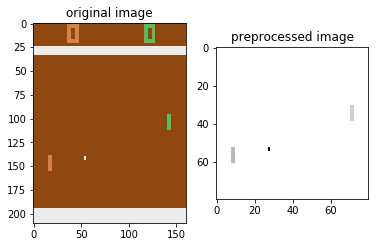

In [3]:
# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


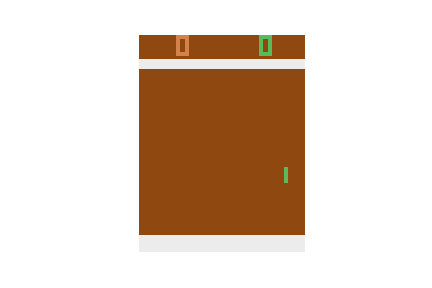
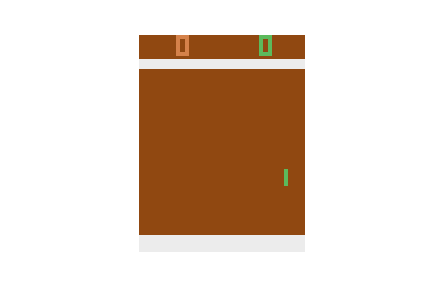
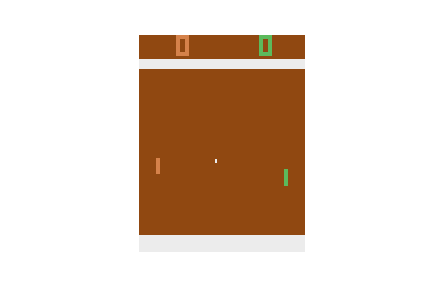
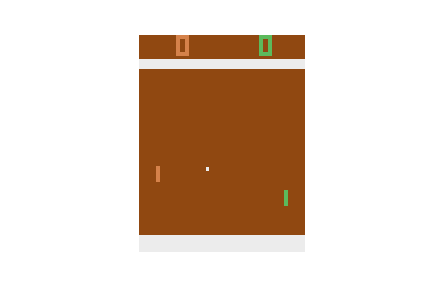
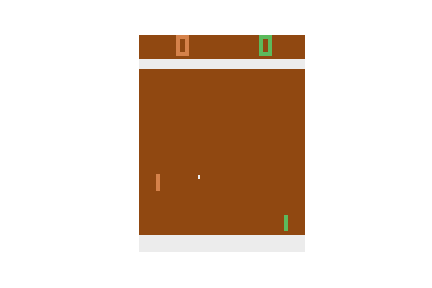
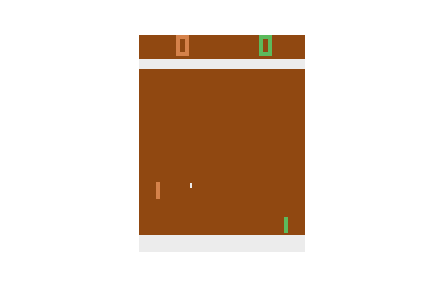
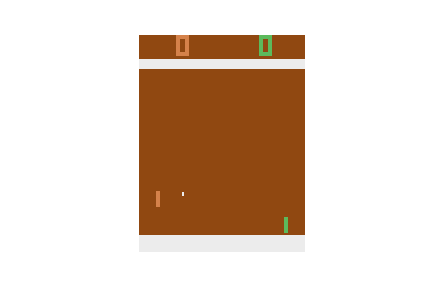
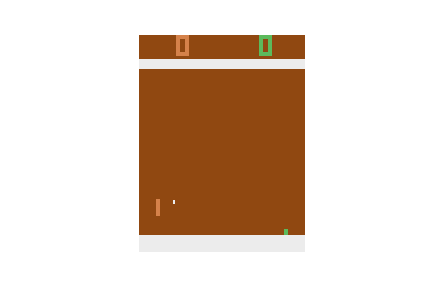
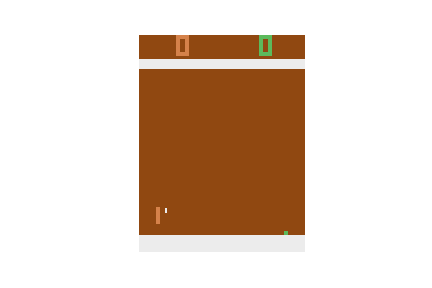
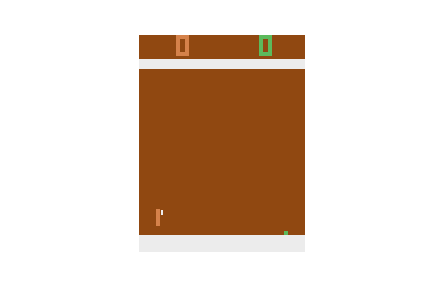
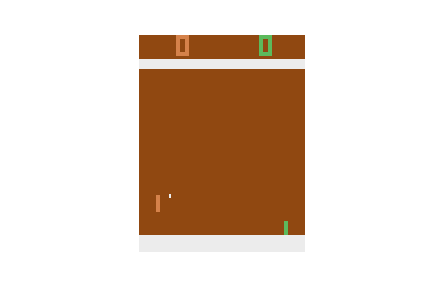
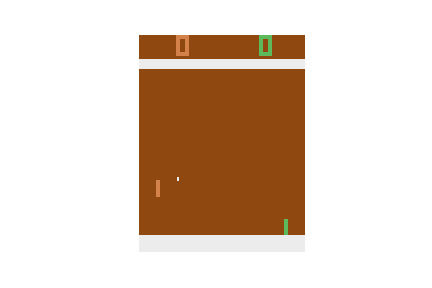
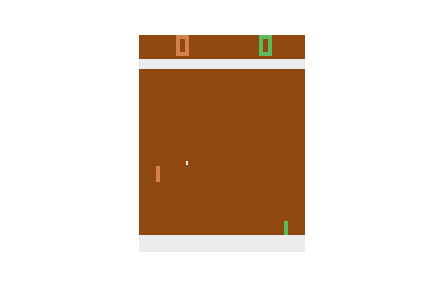
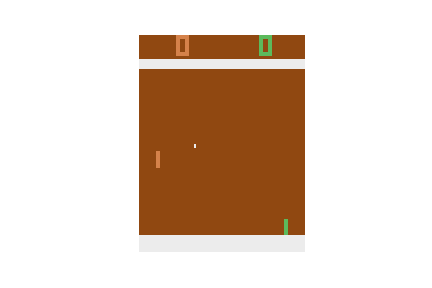
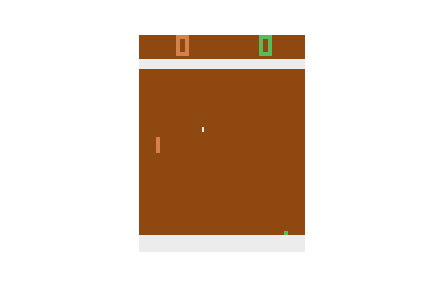
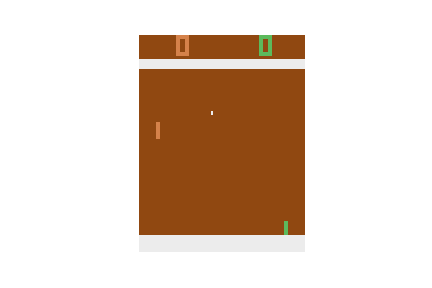
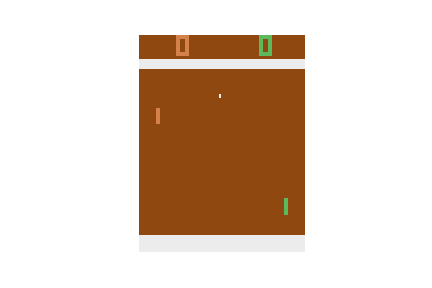
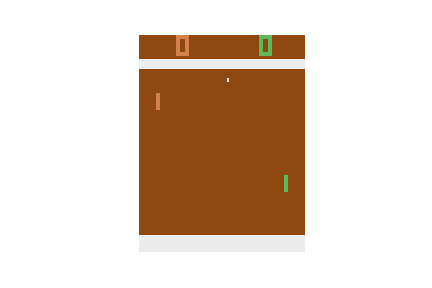
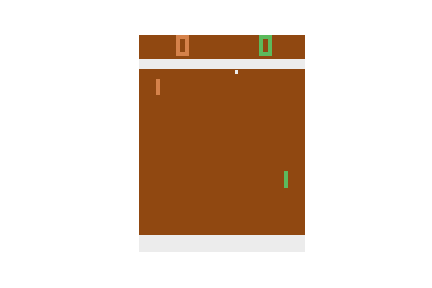
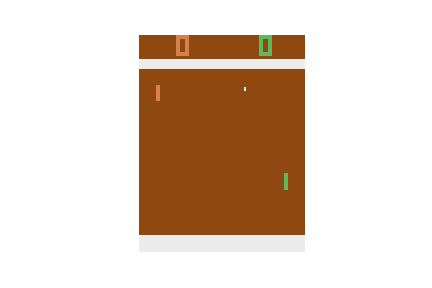
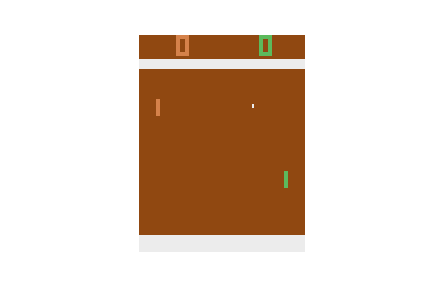
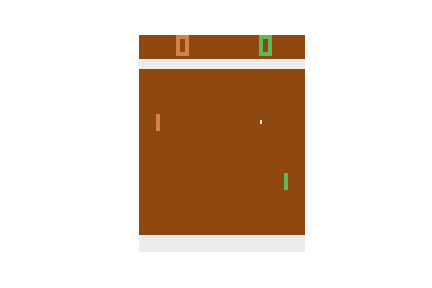
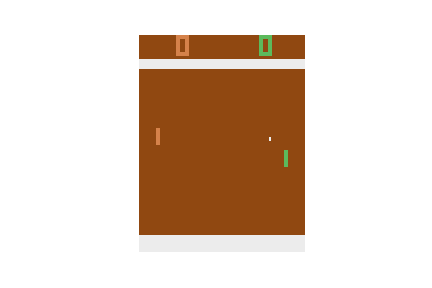
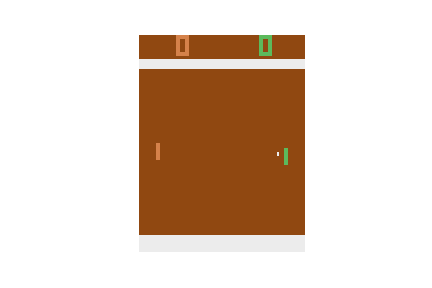
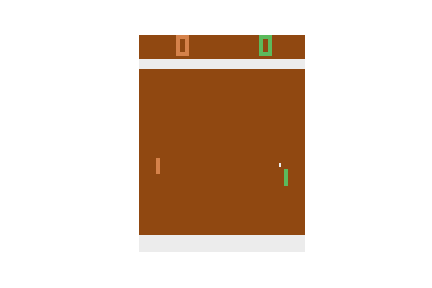
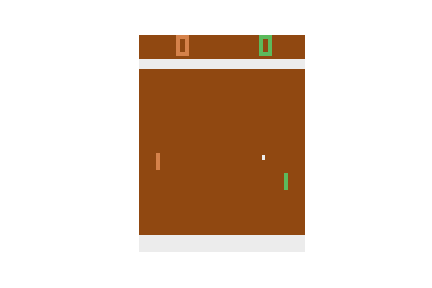
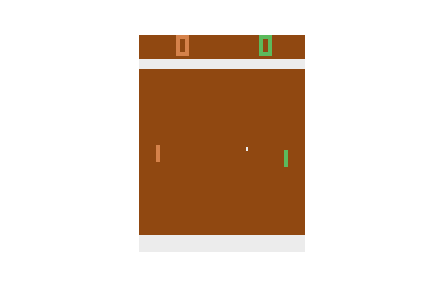
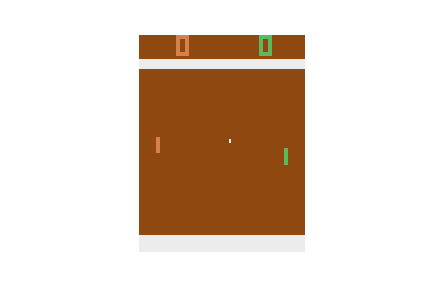
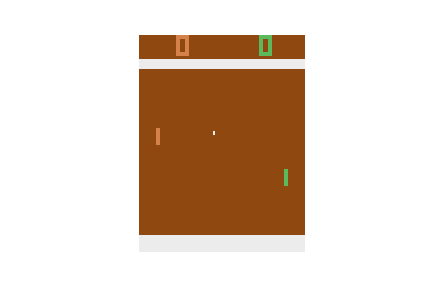
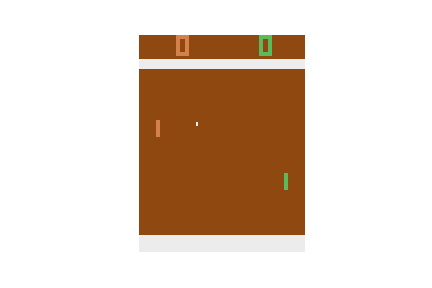
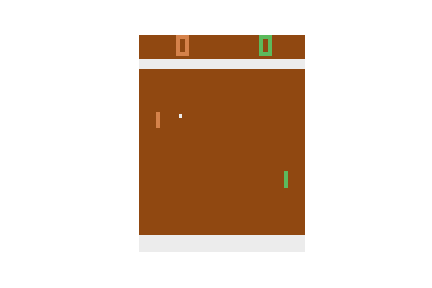
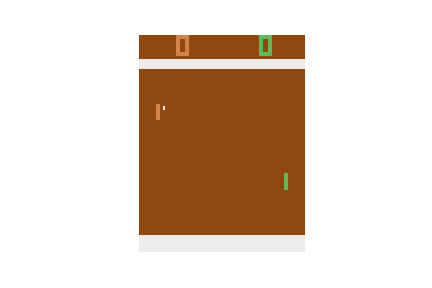
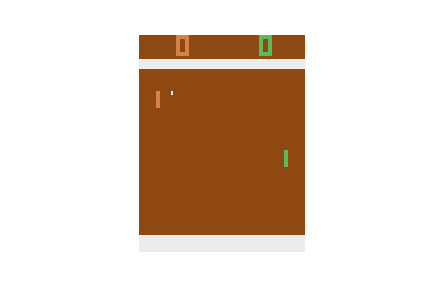
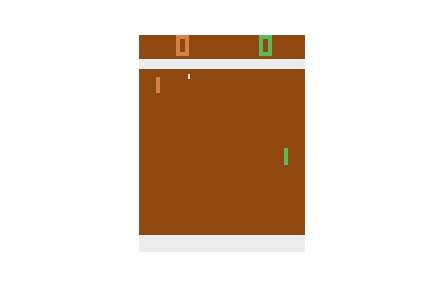
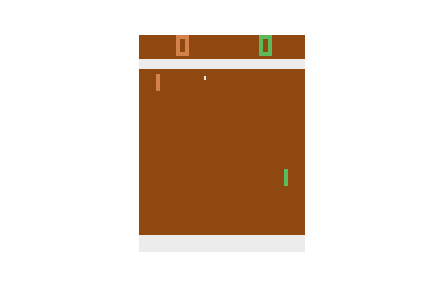
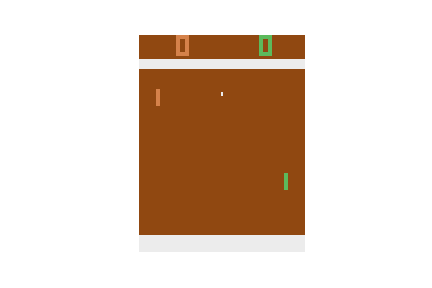
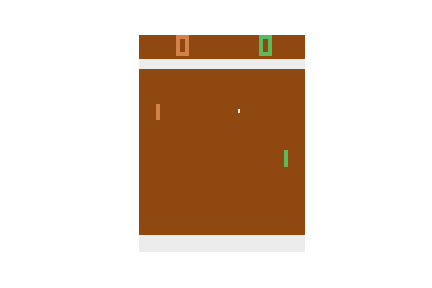
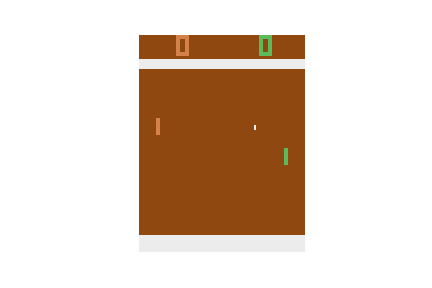
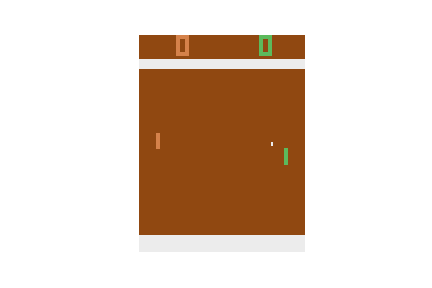
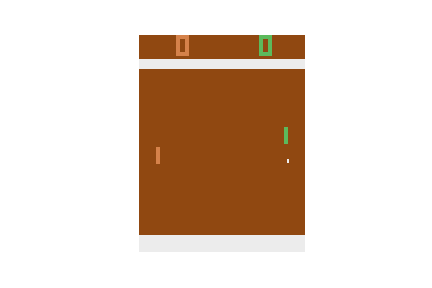
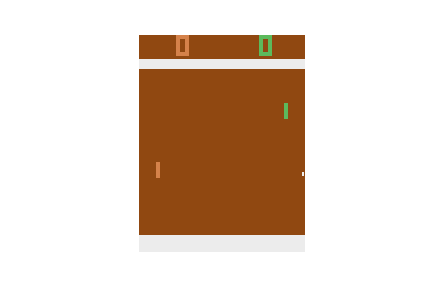
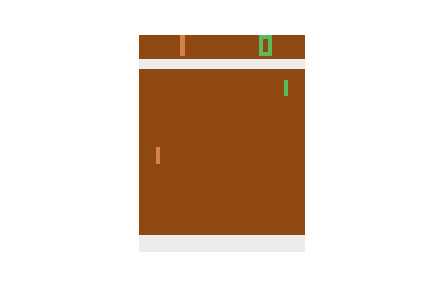
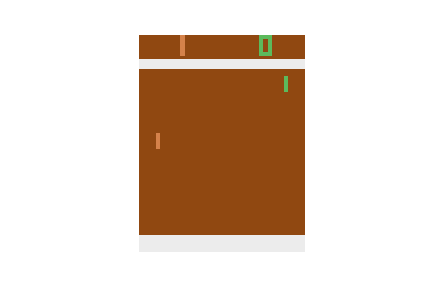
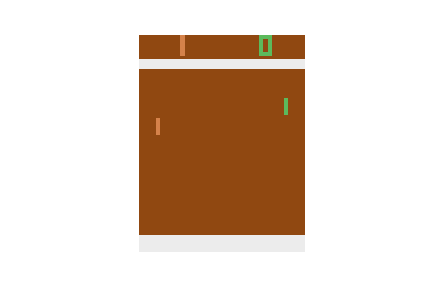
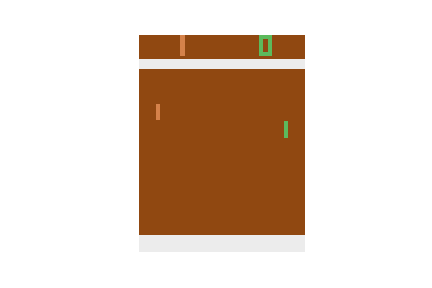
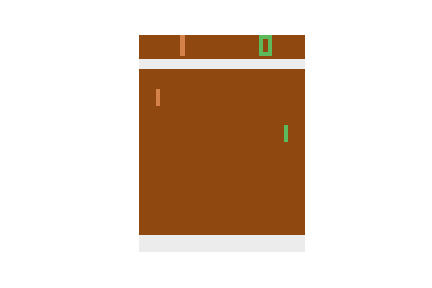
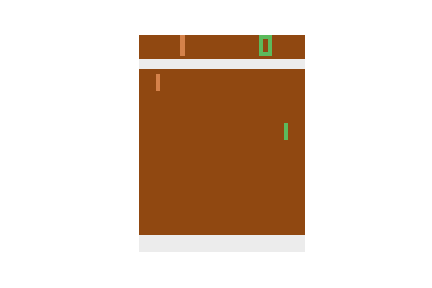
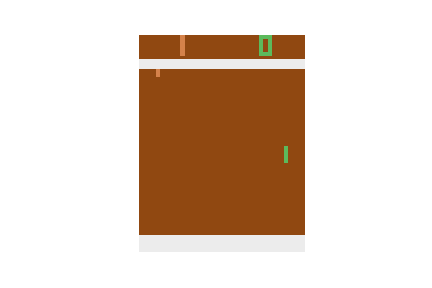
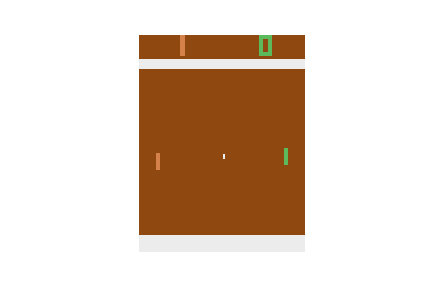
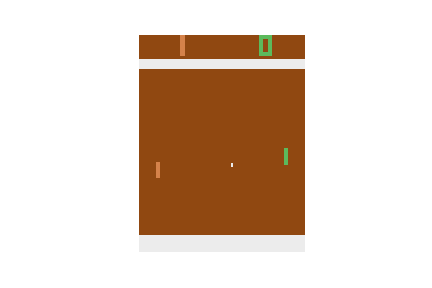
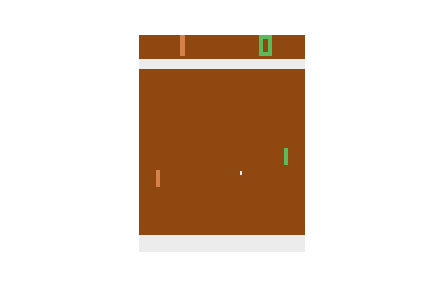
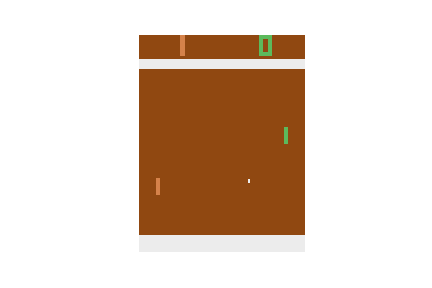
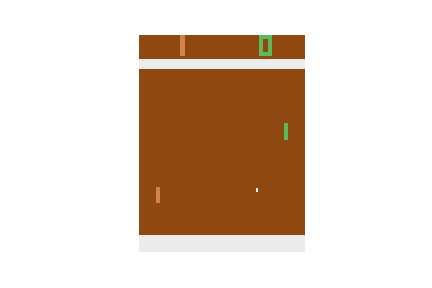
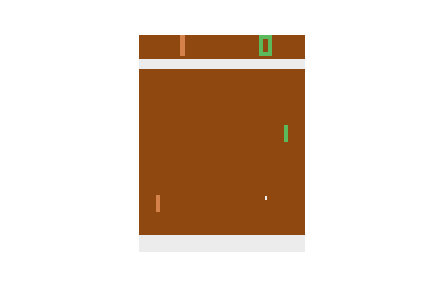
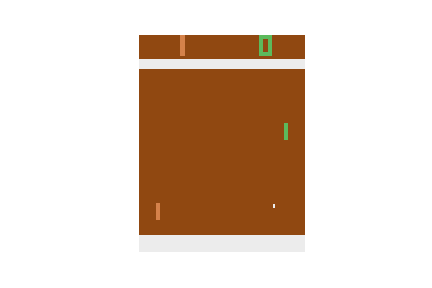
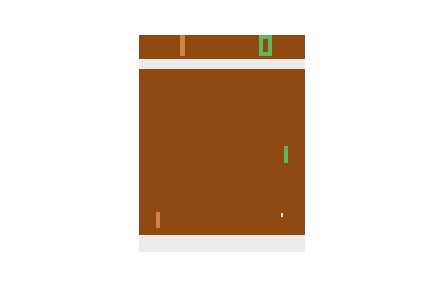
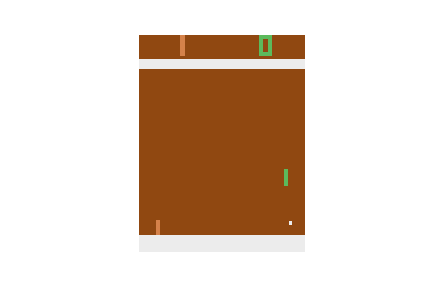
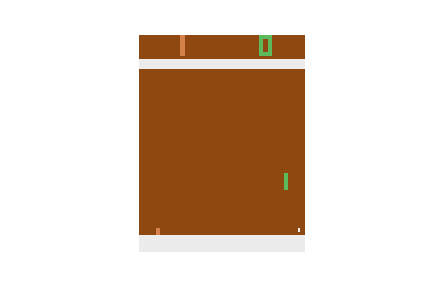
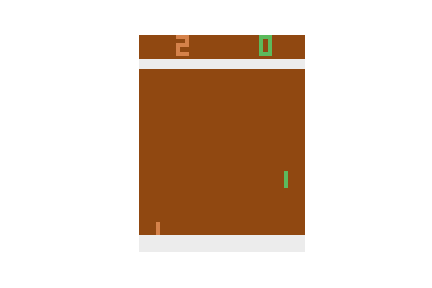
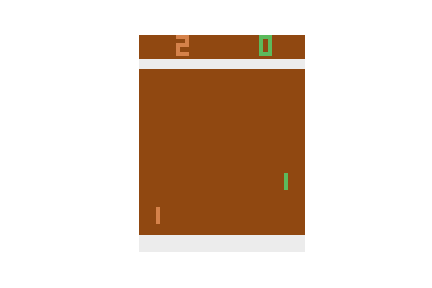
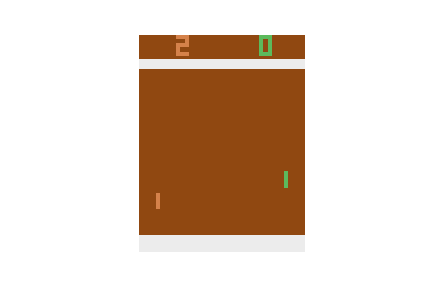
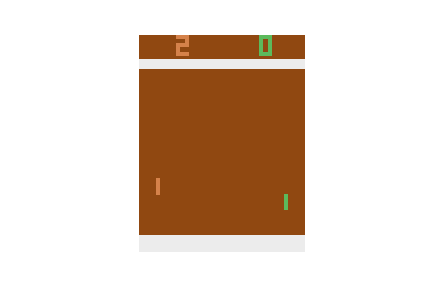
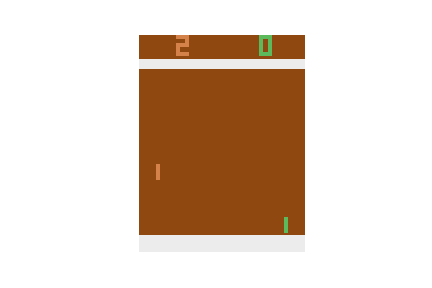
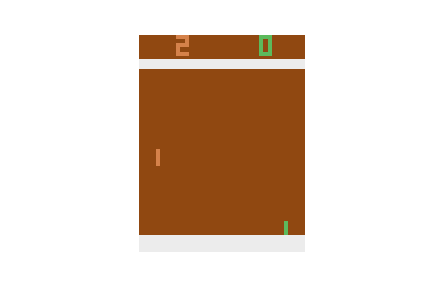
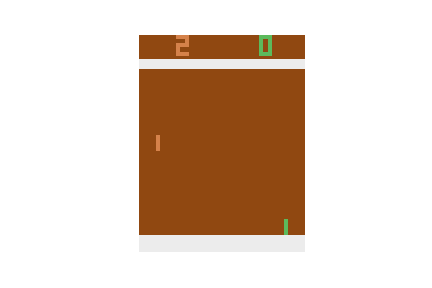
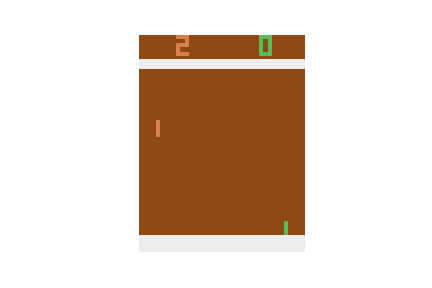
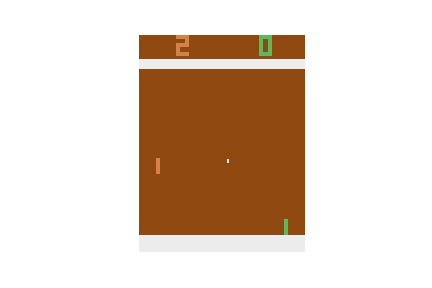
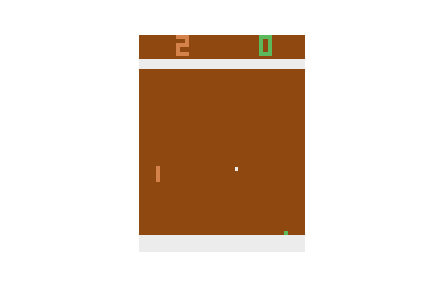
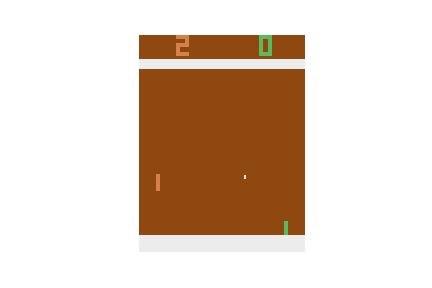
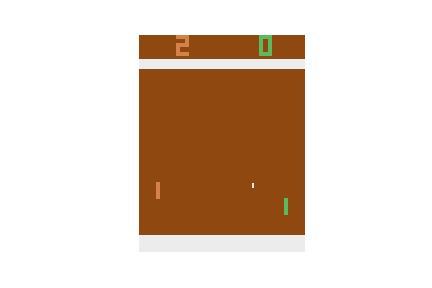
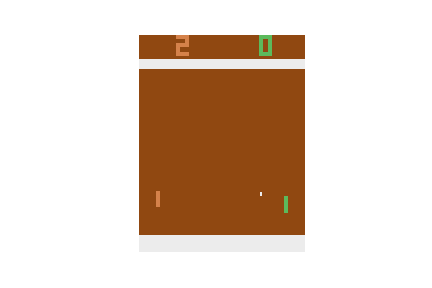
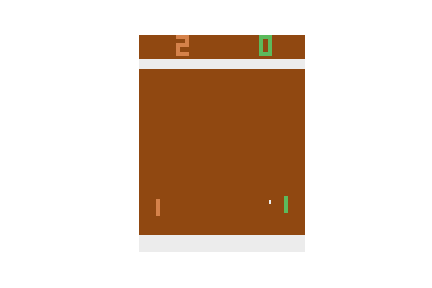
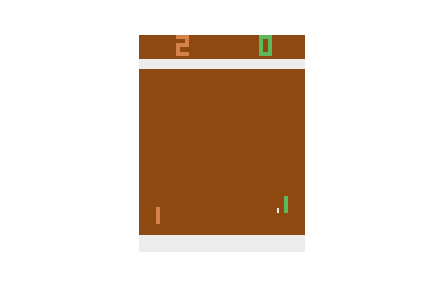
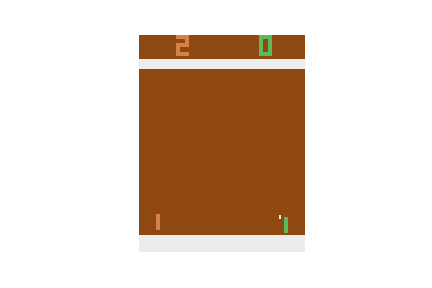
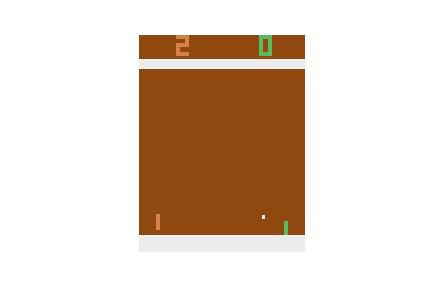
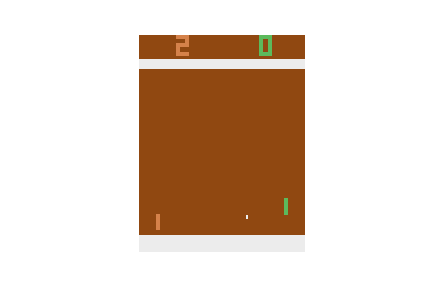
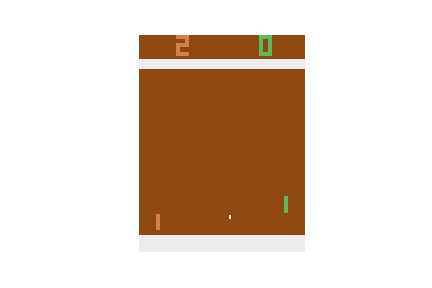
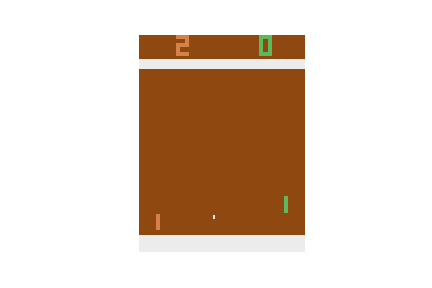
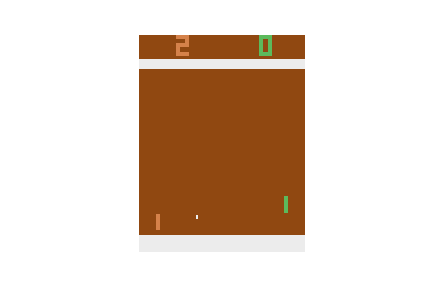
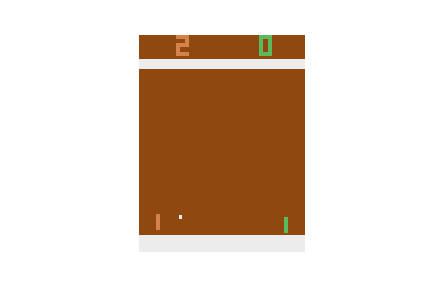
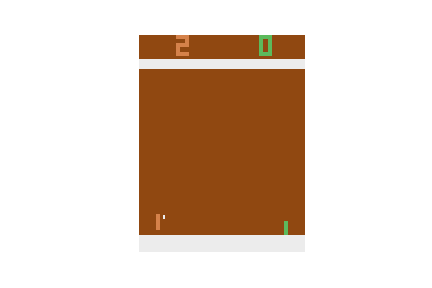
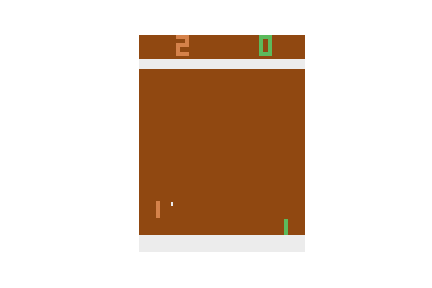
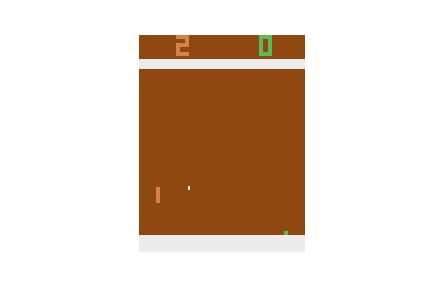
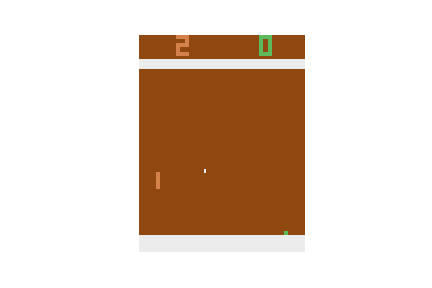
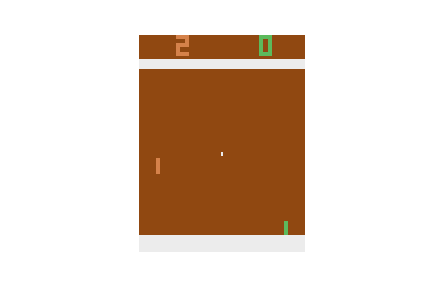
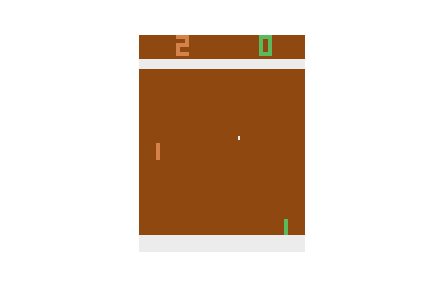
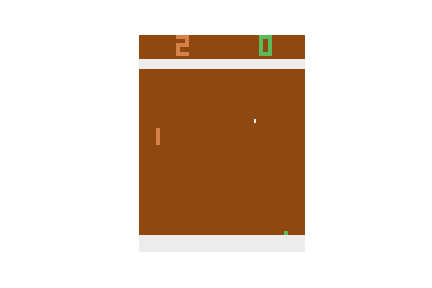
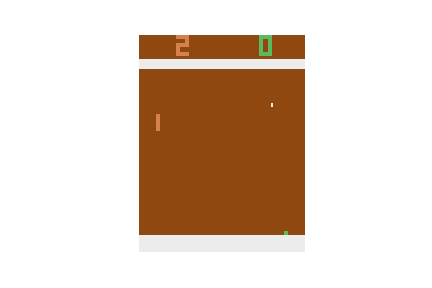
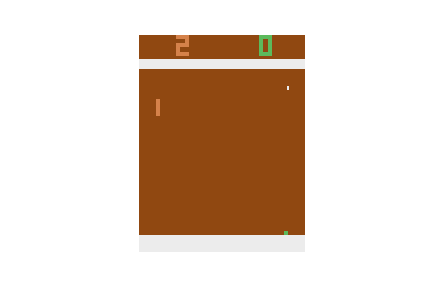
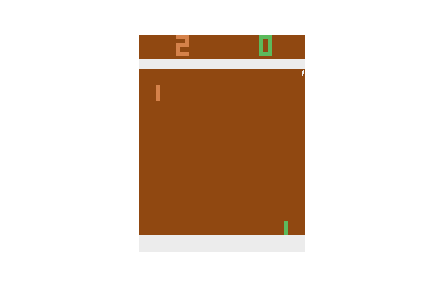
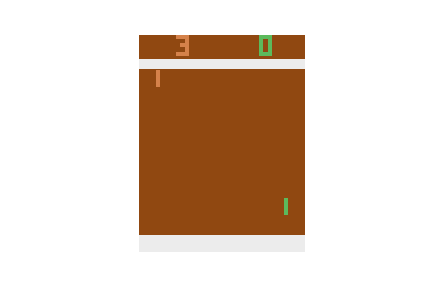
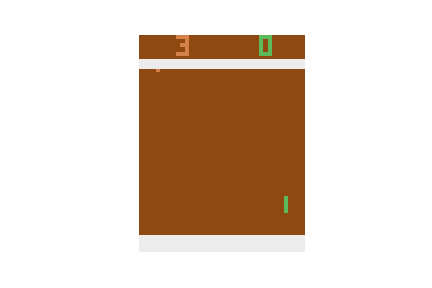
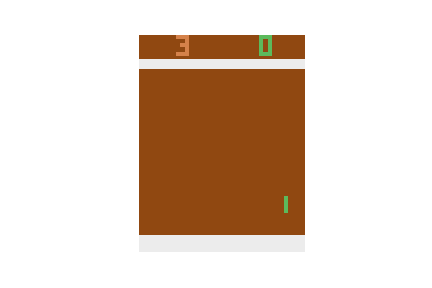
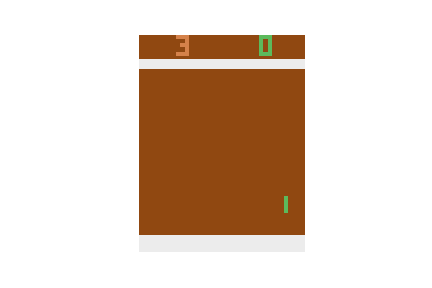
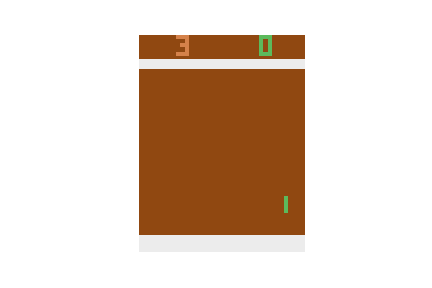
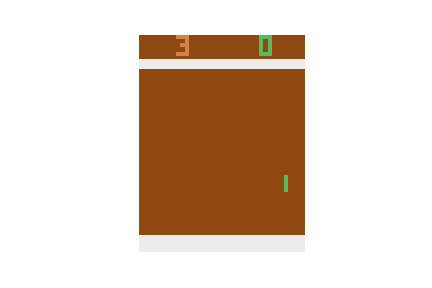
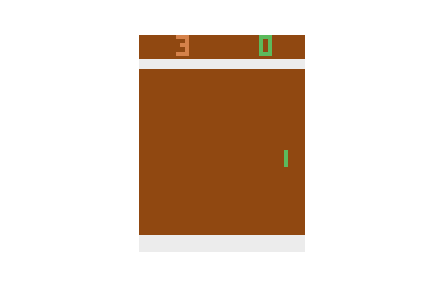
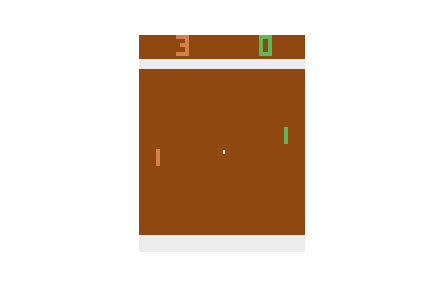
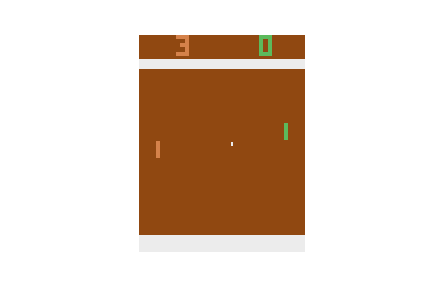
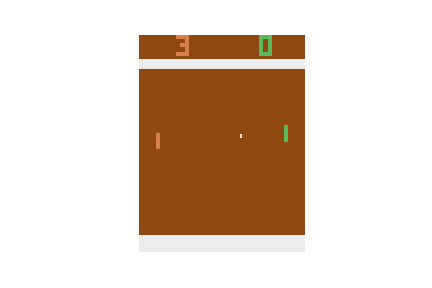
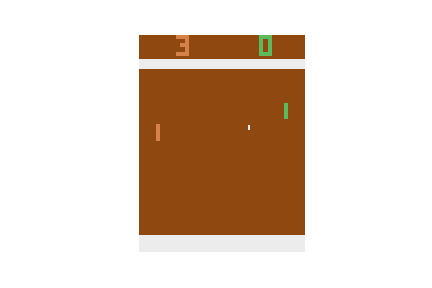
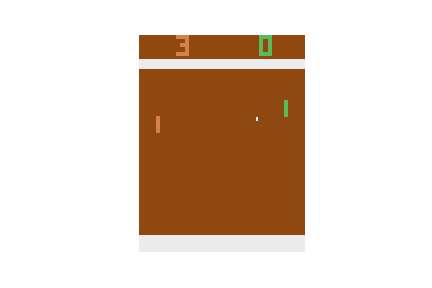
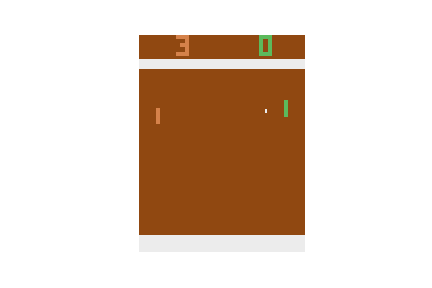
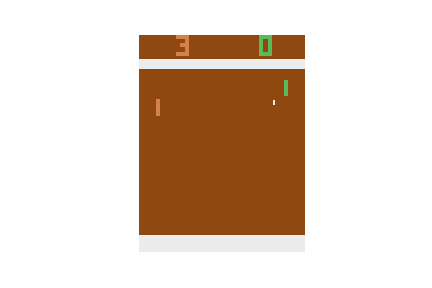
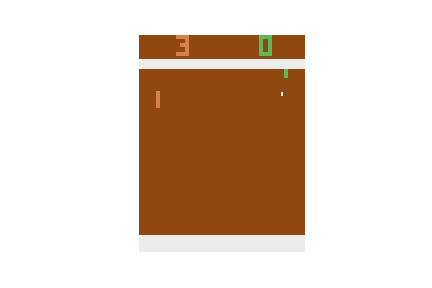
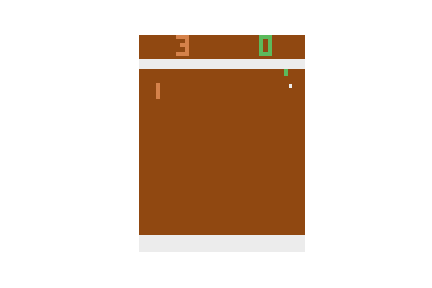
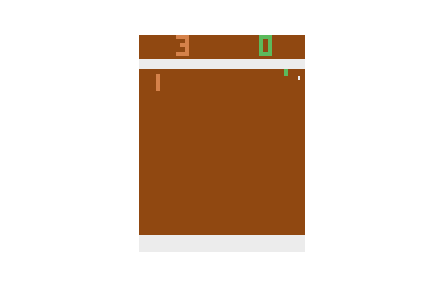
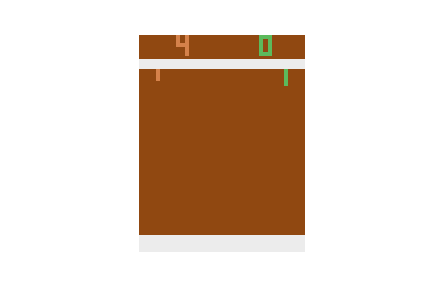
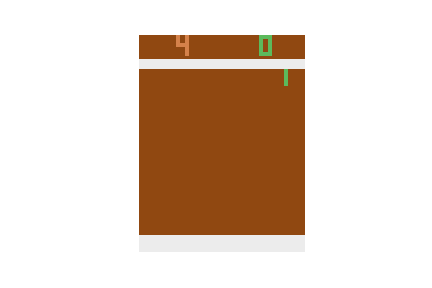
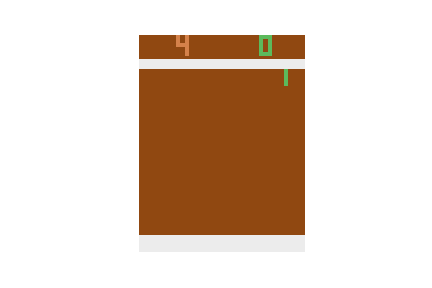
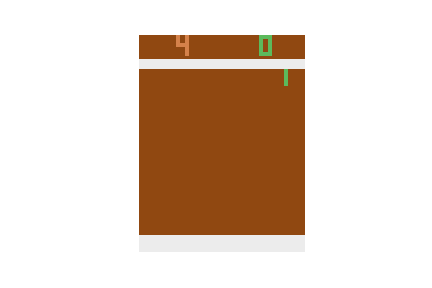
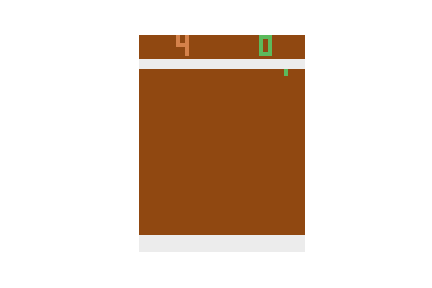
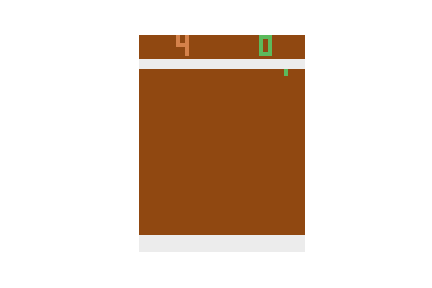
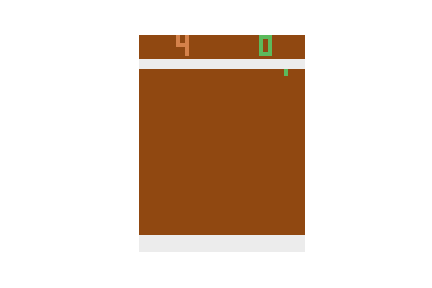
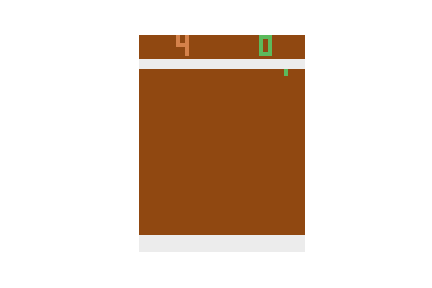
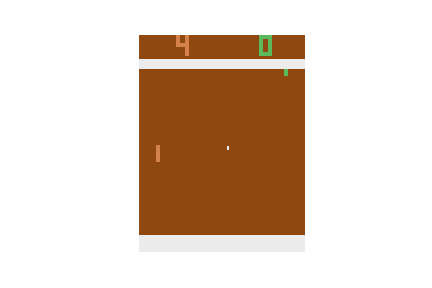
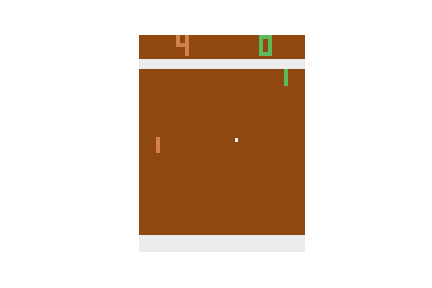
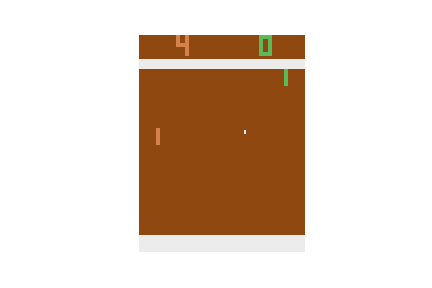
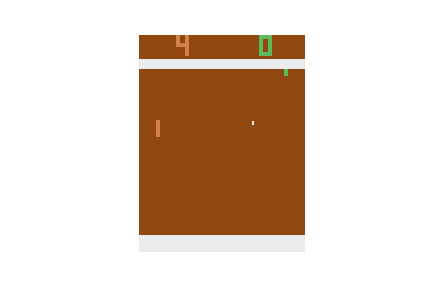
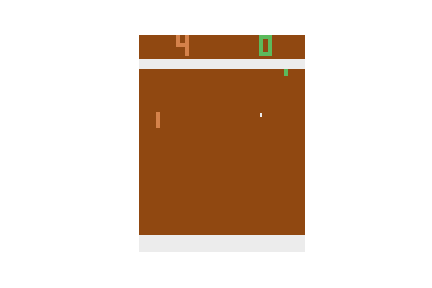
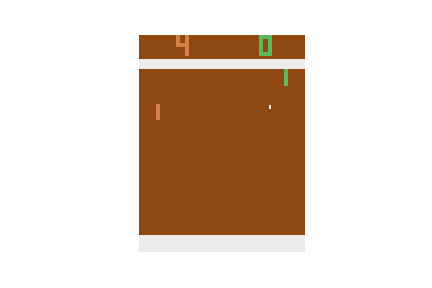
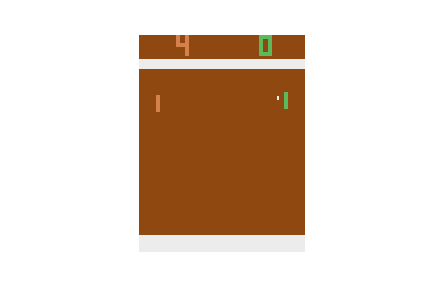
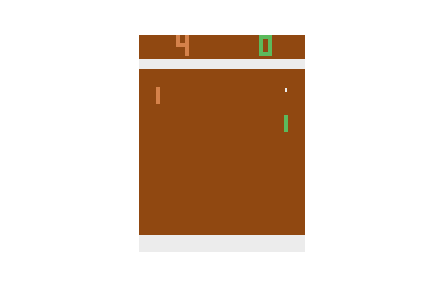
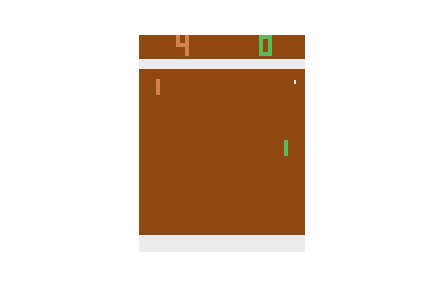
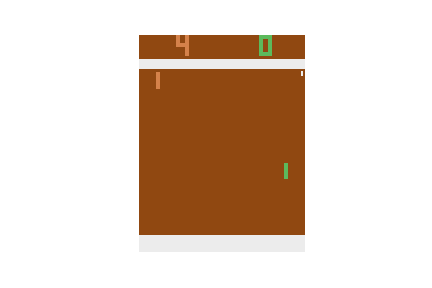
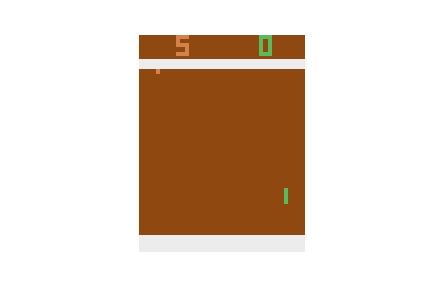
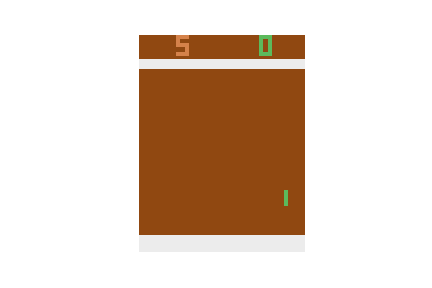
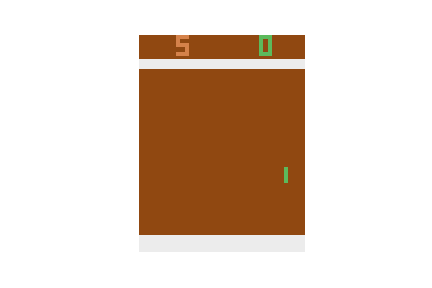
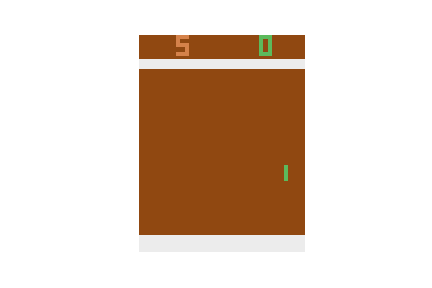
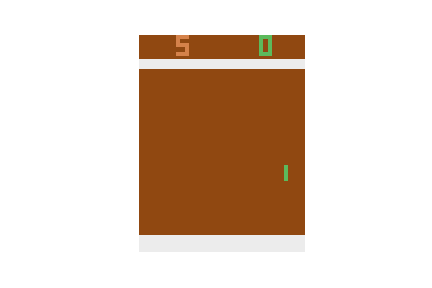
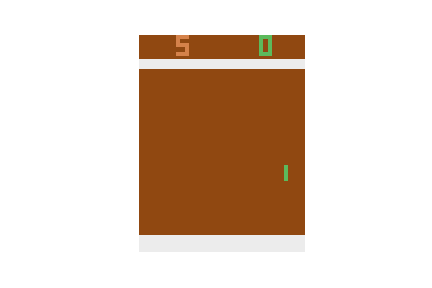
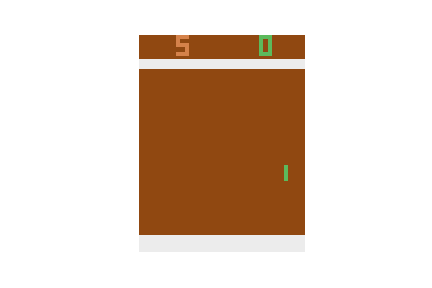
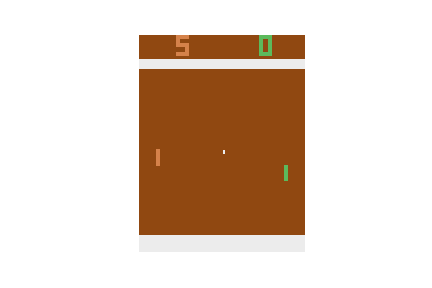
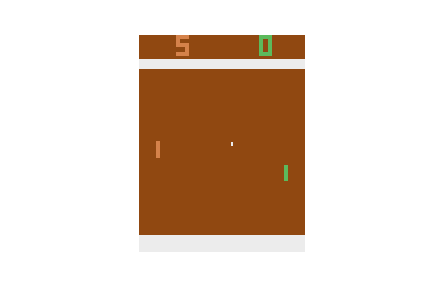
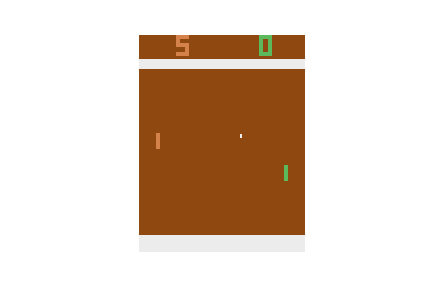
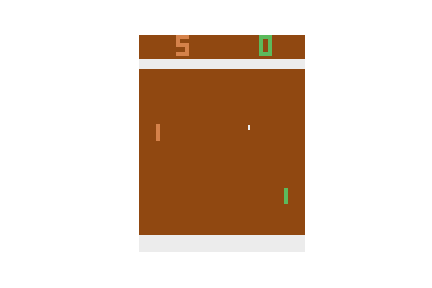
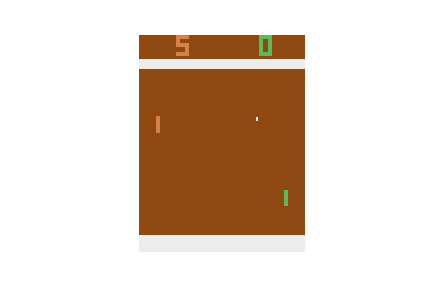
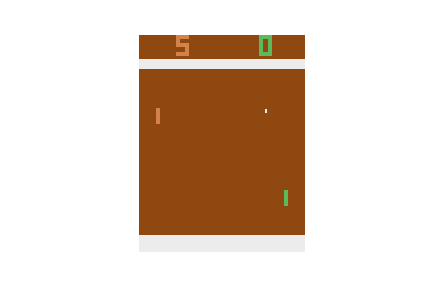
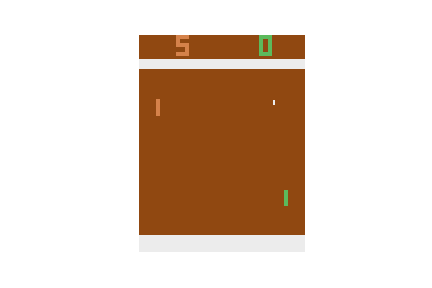
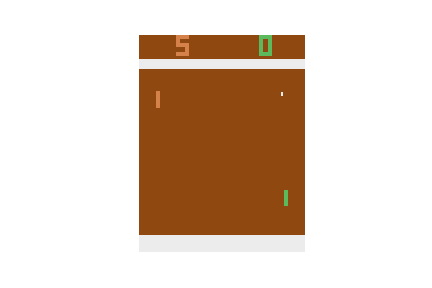
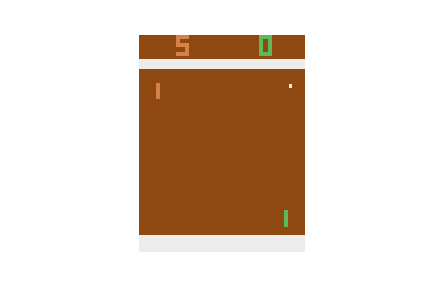
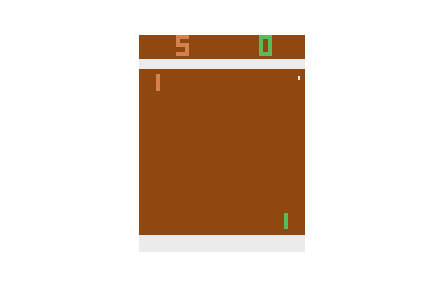
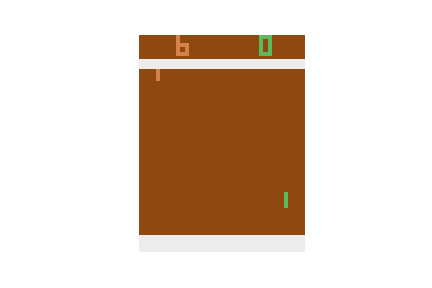
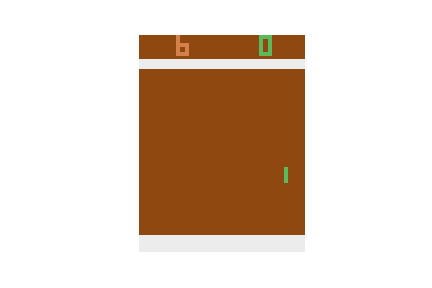
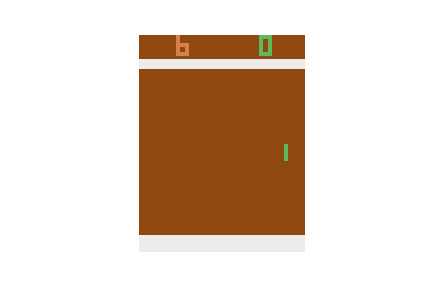
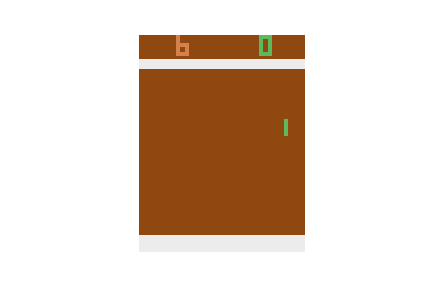
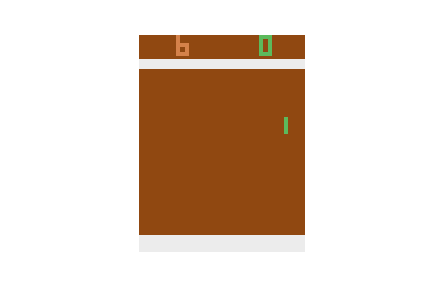
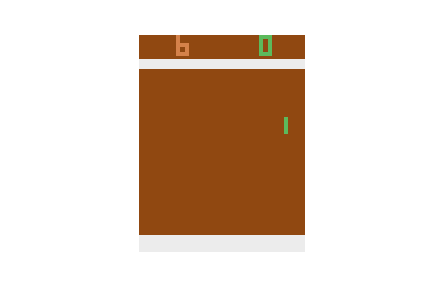
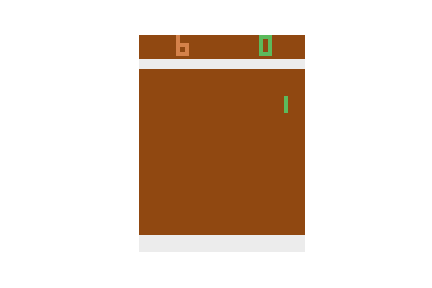
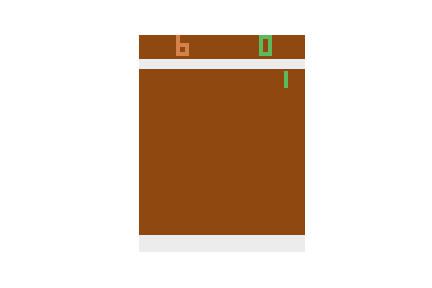
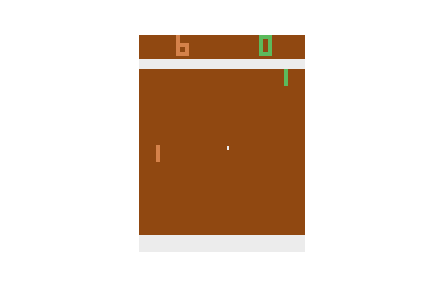
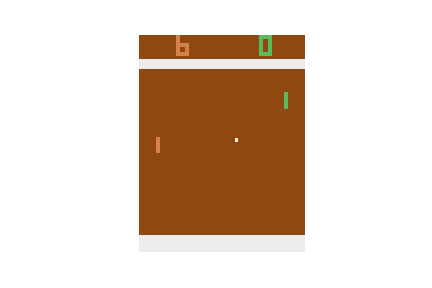
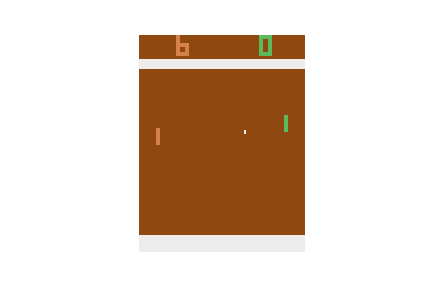
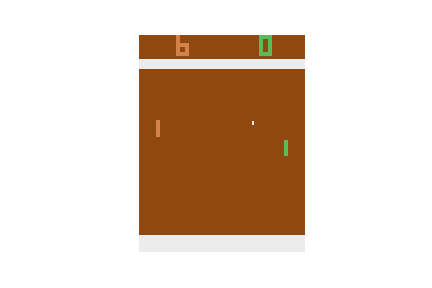
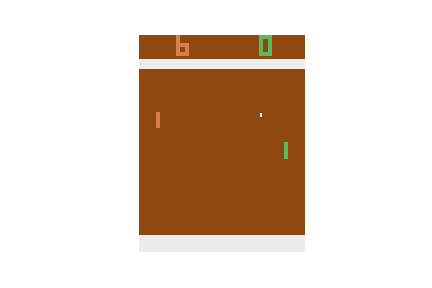
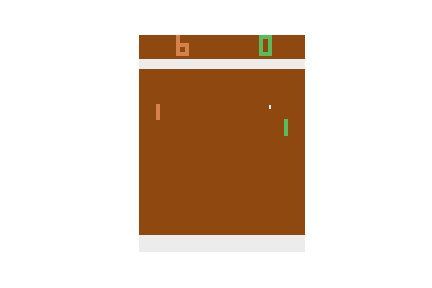
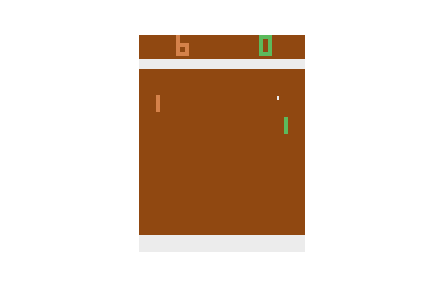
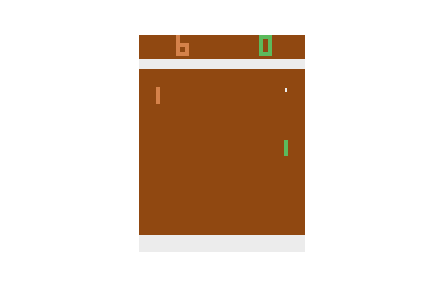
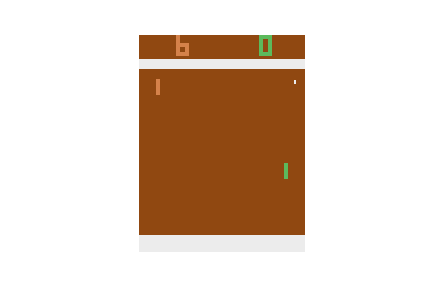
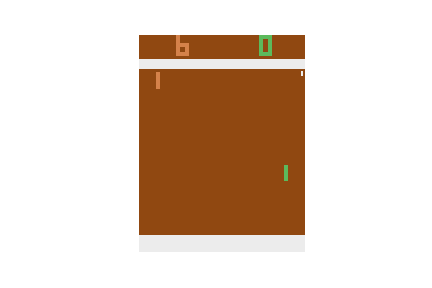
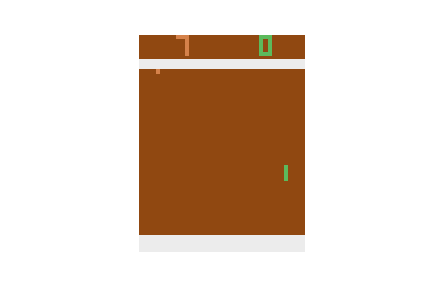
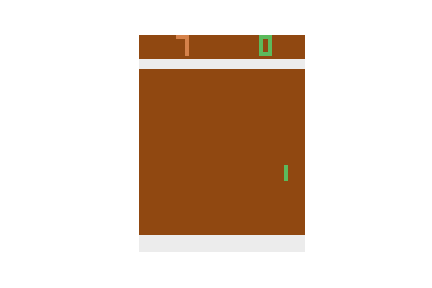
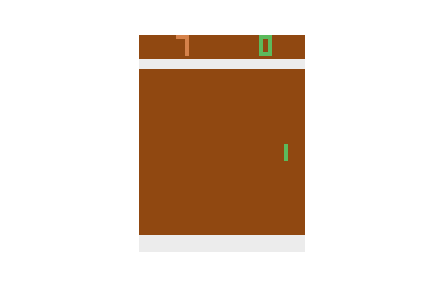
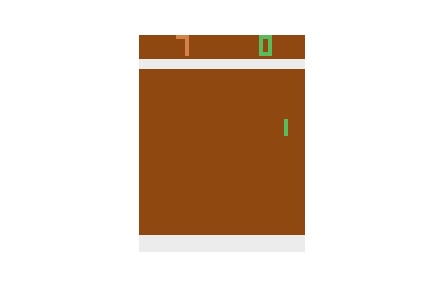
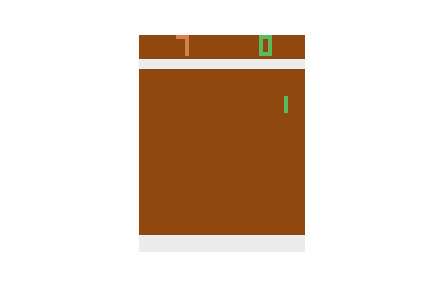
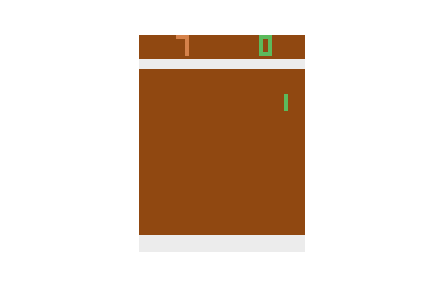
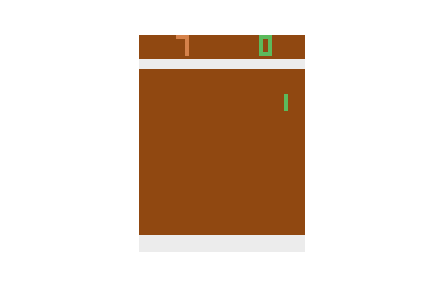
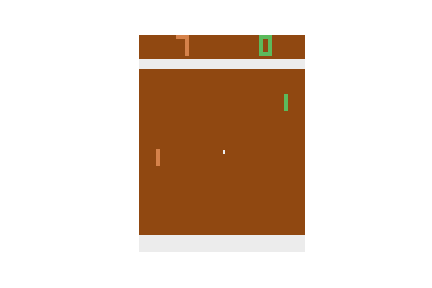
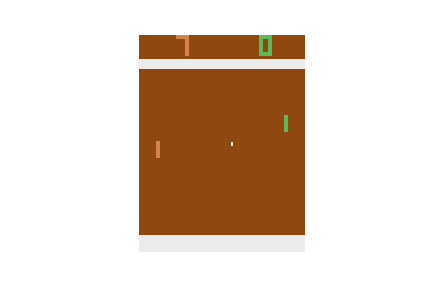
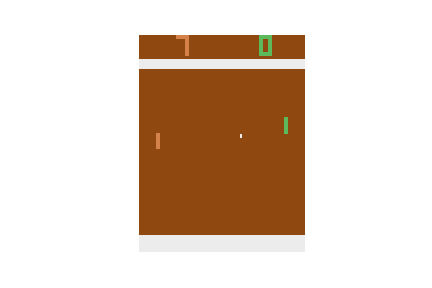
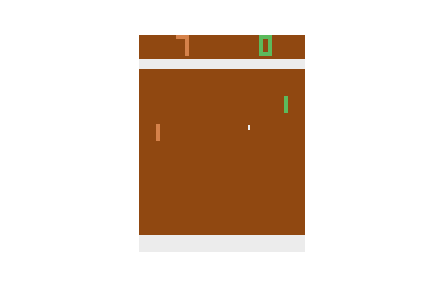
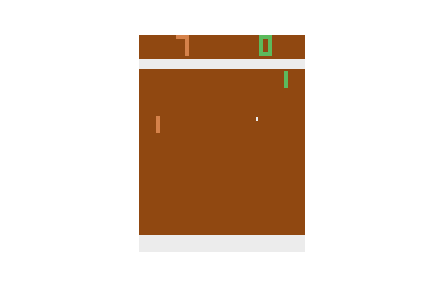
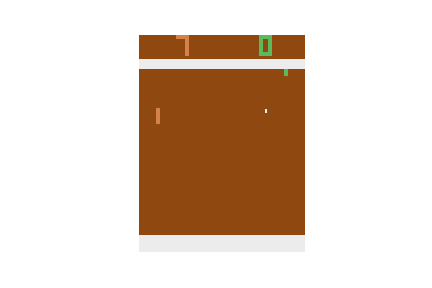
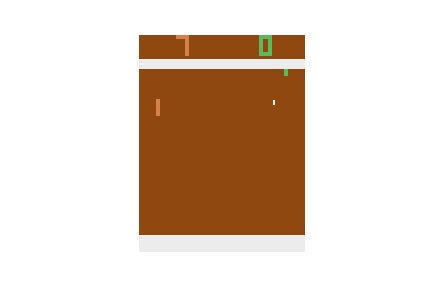
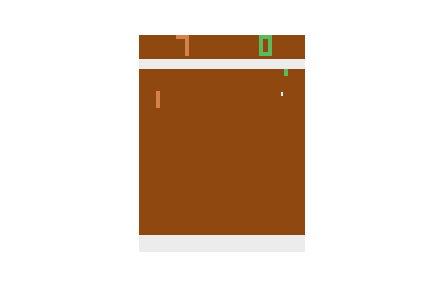
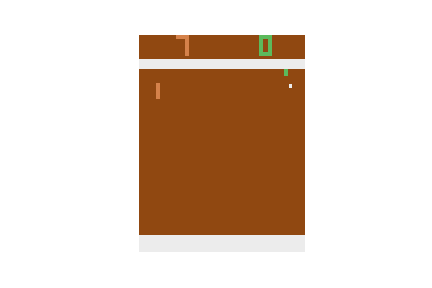
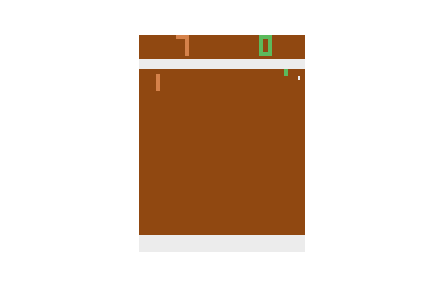
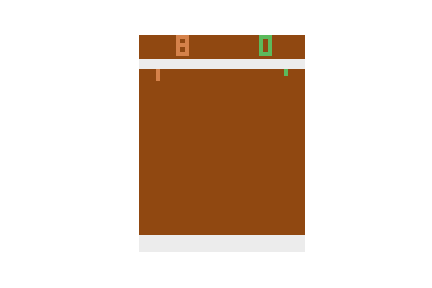
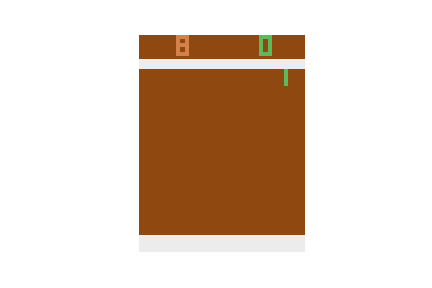
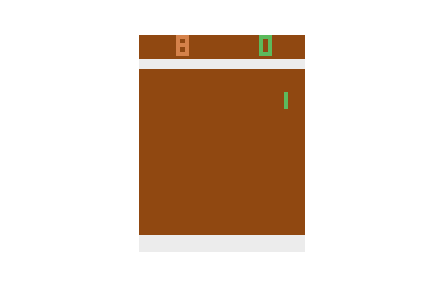
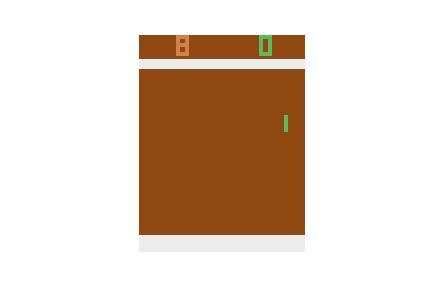
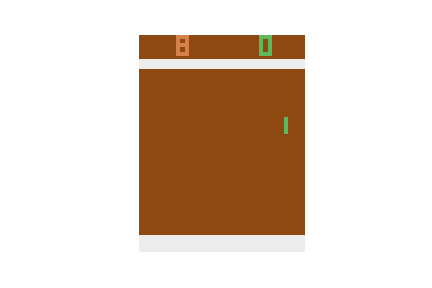
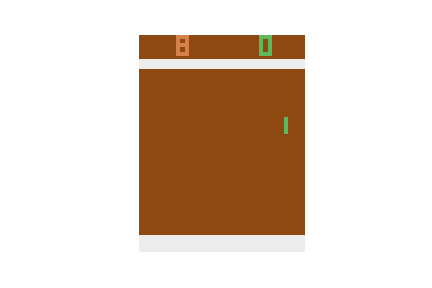
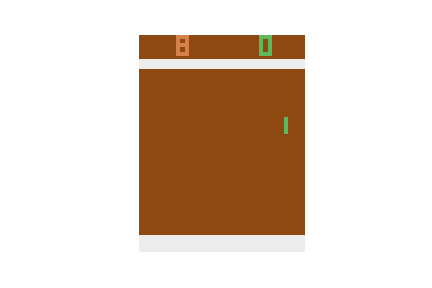
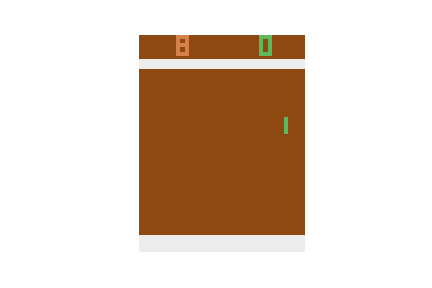
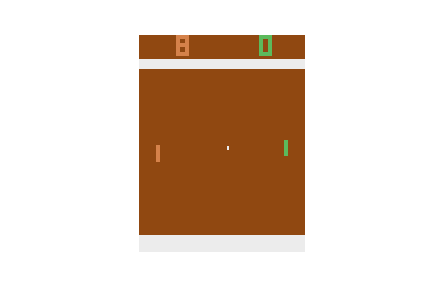
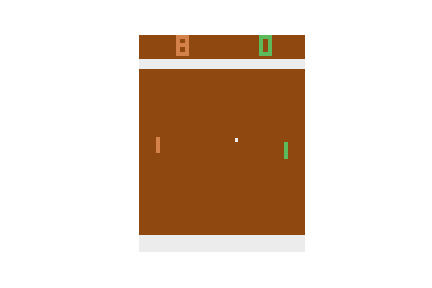
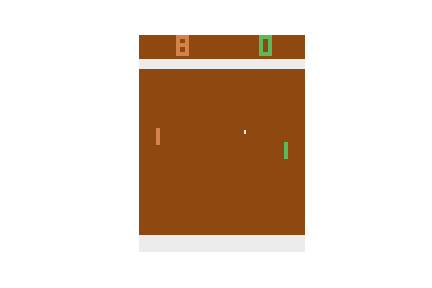
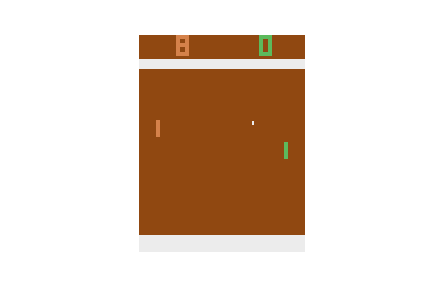
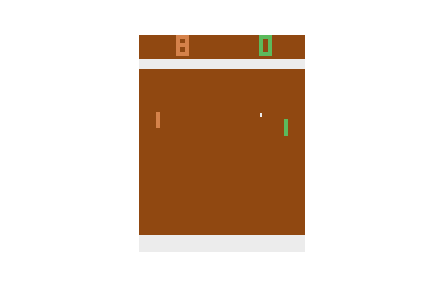
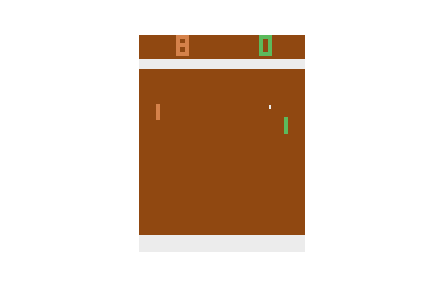
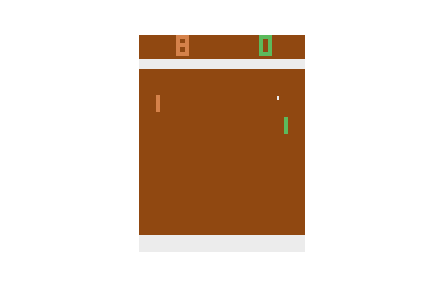
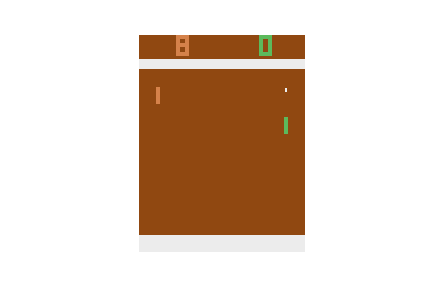
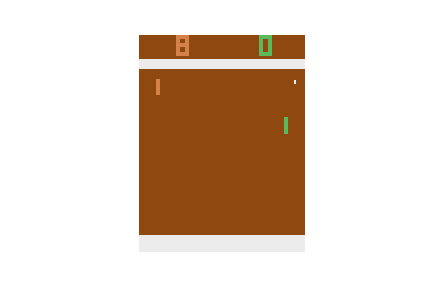
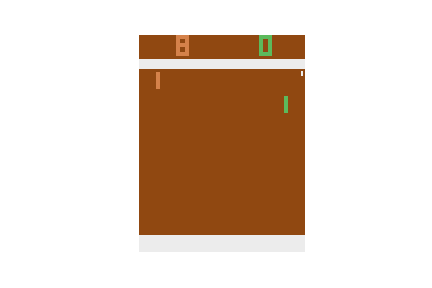
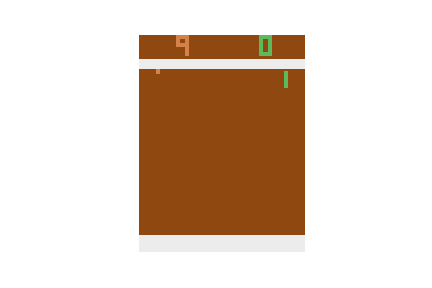
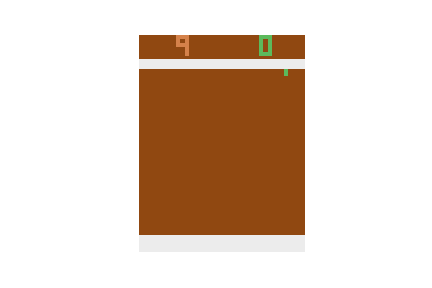
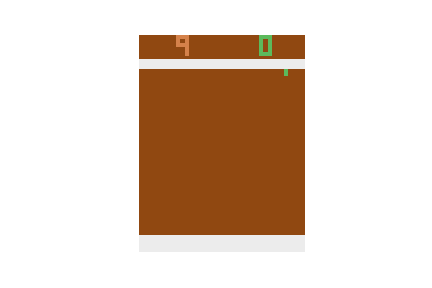
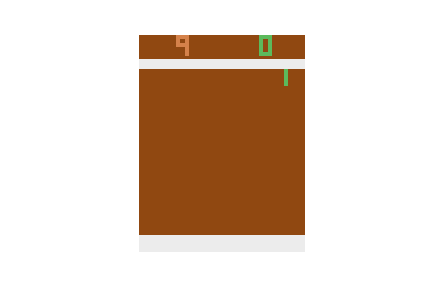
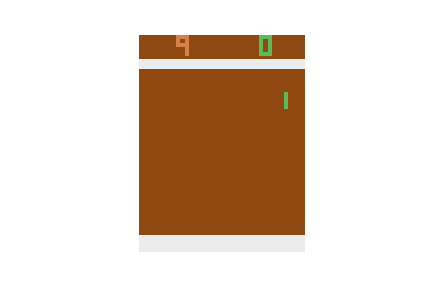

In [4]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

### PPO
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

# Training

In [5]:
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

episode = 500

# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -13.750000
[-16. -14. -13. -12. -14. -16. -16.  -9.]


Episode: 40, score: -13.125000
[-12. -14. -13. -15.  -9. -14. -13. -15.]


Episode: 60, score: -11.750000
[-12.  -9. -11. -12. -16. -16. -10.  -8.]


Episode: 80, score: -13.000000
[-16. -15. -14.  -7. -16.  -9. -11. -16.]


Episode: 100, score: -13.375000
[ -9. -16. -12. -12. -11. -16. -15. -16.]


Episode: 120, score: -12.500000
[ -9. -14. -16. -15. -13. -10. -13. -10.]


Episode: 140, score: -12.875000
[-11. -16. -14. -15.  -9. -15. -12. -11.]


Episode: 160, score: -11.750000
[-11. -15. -10.  -9. -11. -13. -15. -10.]


Episode: 180, score: -9.500000
[-13.  -9. -12. -12.  -5. -10.  -5. -10.]


Episode: 200, score: -8.250000
[ -8.  -9. -13.  -7.  -4.  -8.  -6. -11.]


Episode: 220, score: -6.750000
[ -5.  -7.  -8.  -5.  -5. -13.  -5.  -6.]


Episode: 240, score: -5.625000
[-9. -8. -8. -6. -7. -4. -2. -1.]


Episode: 260, score: -2.250000
[-6. -4. -3. -1. -3.  0. -2.  1.]


Episode: 280, score: -4.125000
[-5. -6. -5. -1. -2. -5. -5. -4.]


Episode: 300, score: -1.625000
[-2. -2. -4. -1.  0. -1. -1. -2.]


Episode: 320, score: -1.500000
[-3. -1. -2.  1. -1.  0. -5. -1.]


Episode: 340, score: 0.125000
[ 0.  1. -2.  0.  0.  0.  1.  1.]


Episode: 360, score: 0.375000
[ 0.  2. -1. -2. -1.  2.  2.  1.]


Episode: 380, score: -0.625000
[-2. -3. -1.  0.  0. -2.  2.  1.]


Episode: 400, score: -0.250000
[-1.  1. -2.  1.  0.  0.  1. -2.]


Episode: 420, score: -1.125000
[-1.  4.  0.  0. -7. -1. -1. -3.]


Episode: 440, score: 0.000000
[-4.  3.  3.  0. -1. -1.  0.  0.]


Episode: 460, score: 1.000000
[1. 0. 0. 0. 2. 2. 2. 1.]


Episode: 480, score: 1.875000
[3. 1. 1. 1. 3. 1. 2. 3.]


Episode: 500, score: 2.375000
[ 3.  3.  3.  3.  2. -1.  3.  3.]



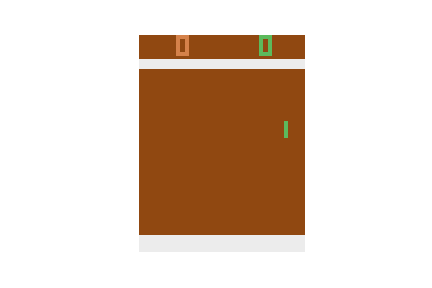
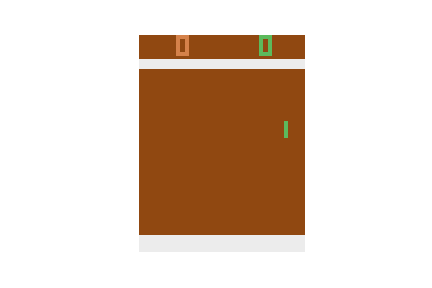
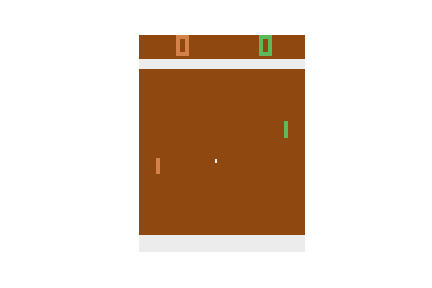
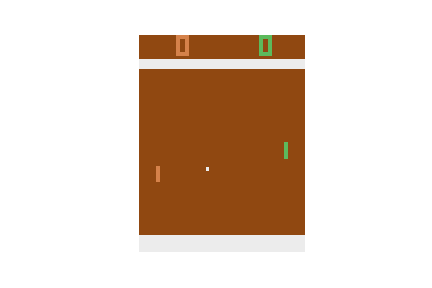
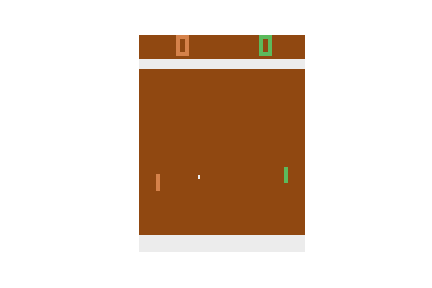
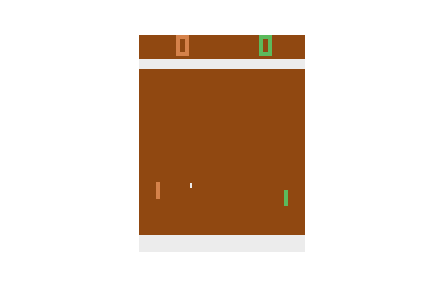
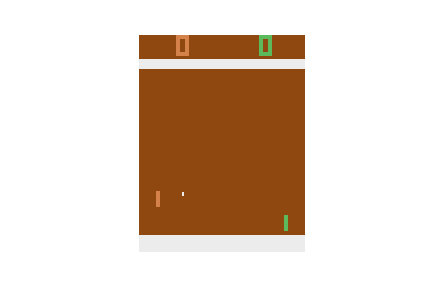
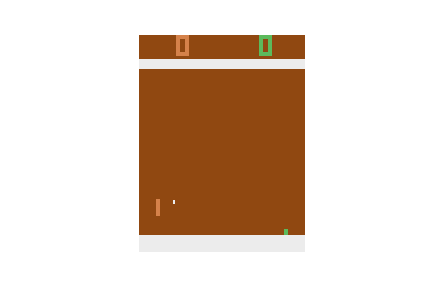
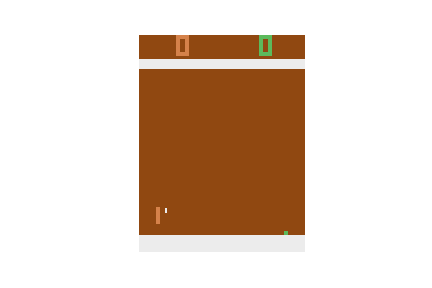
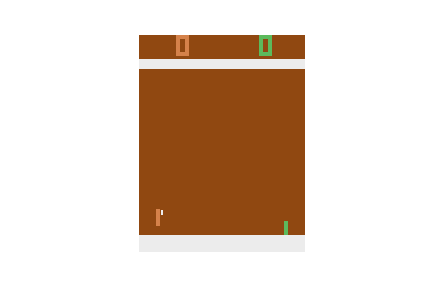
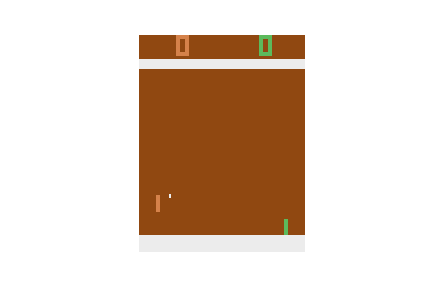
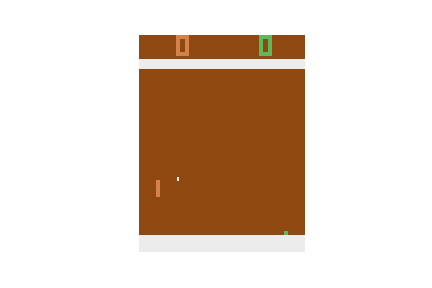
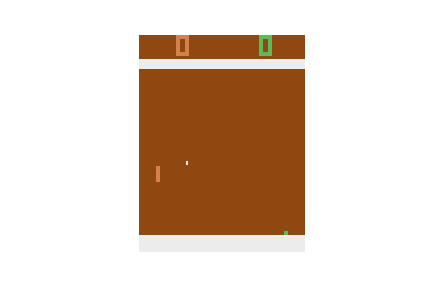
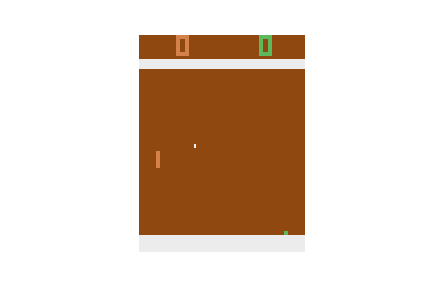
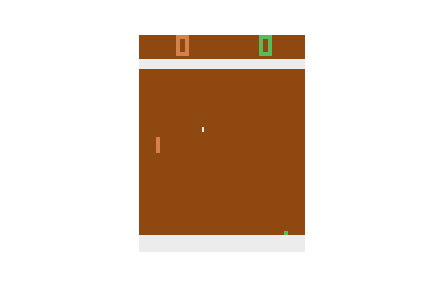
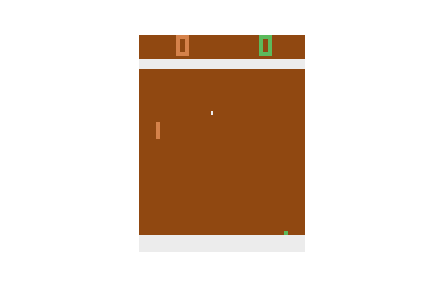
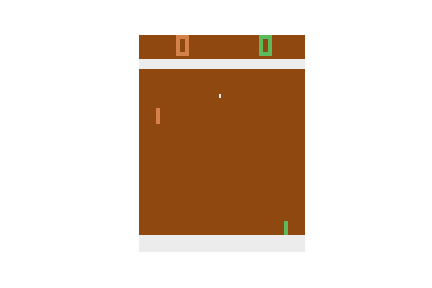
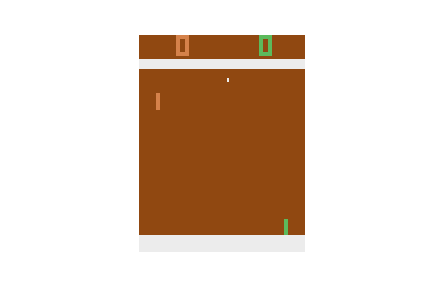
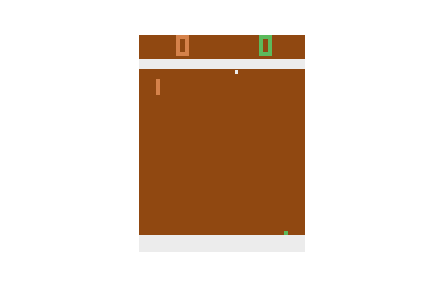
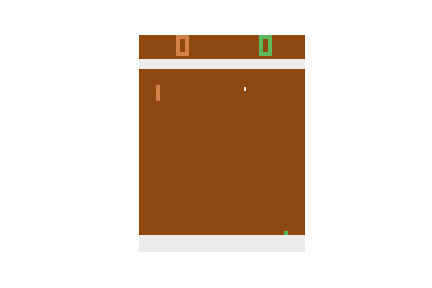
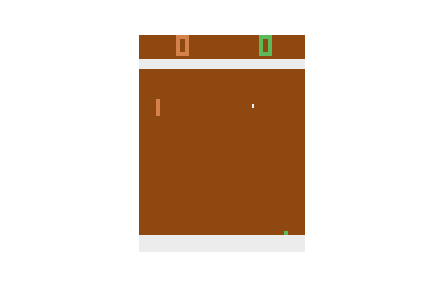
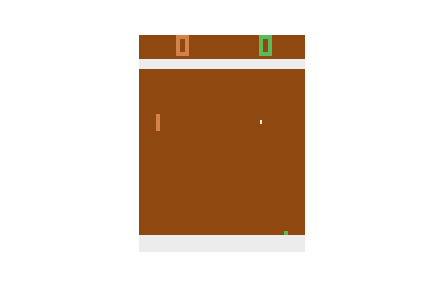
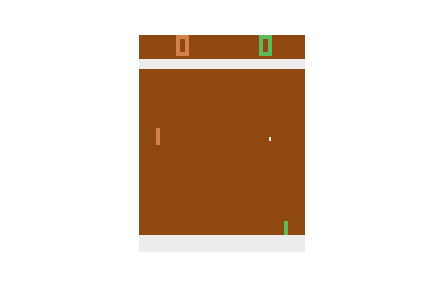
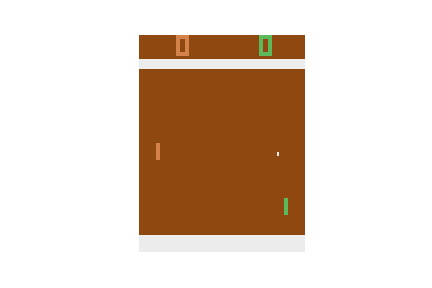
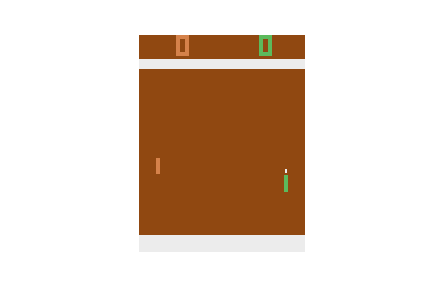
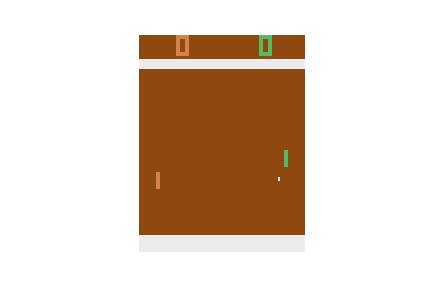
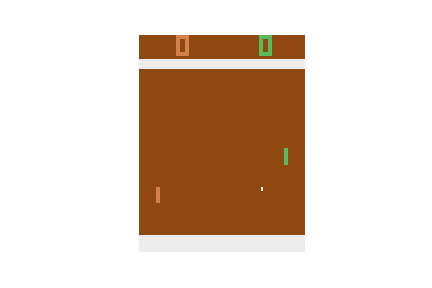
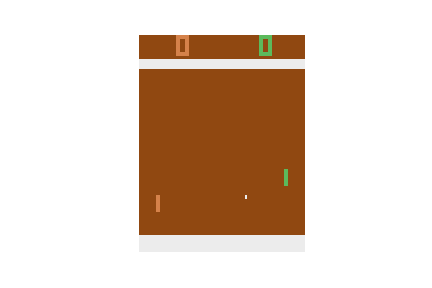
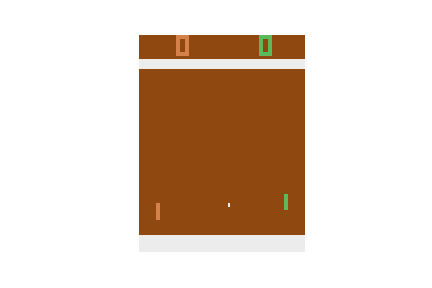
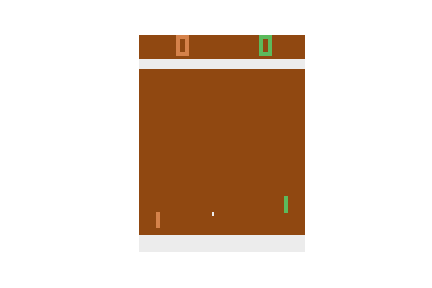
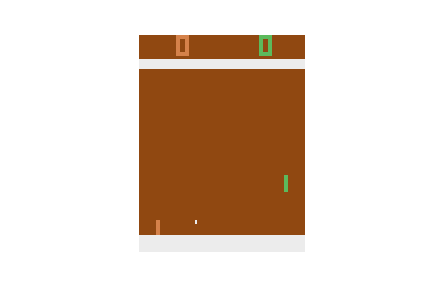
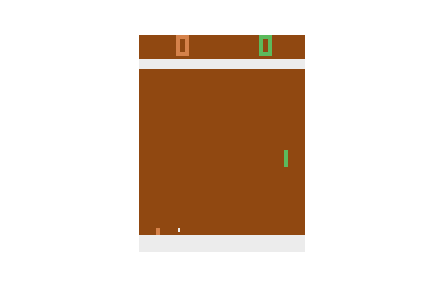
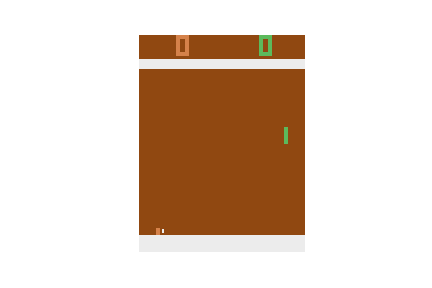
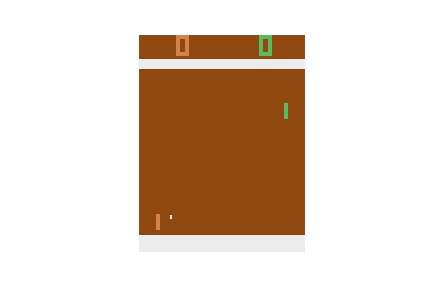
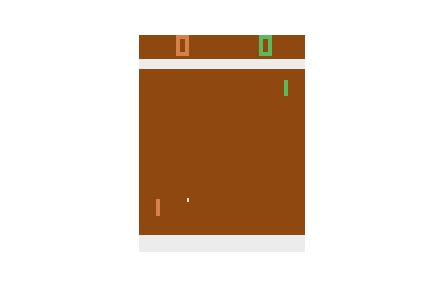
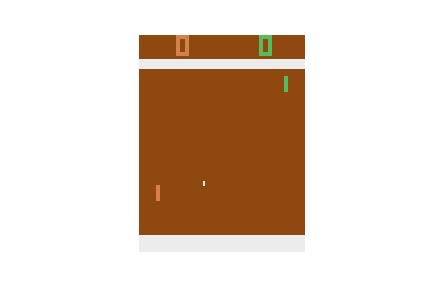
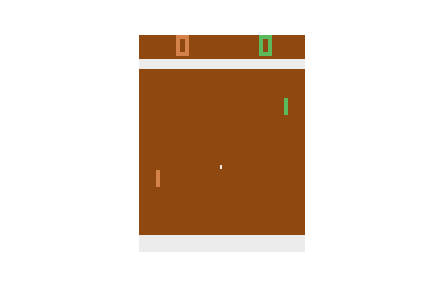
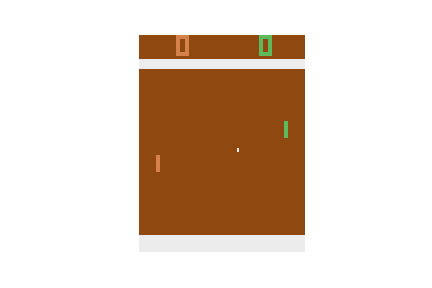
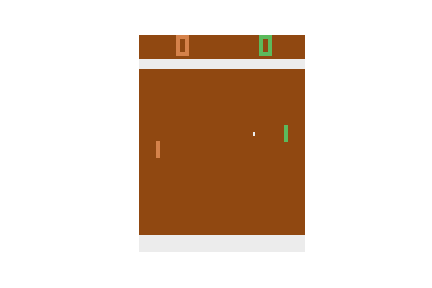
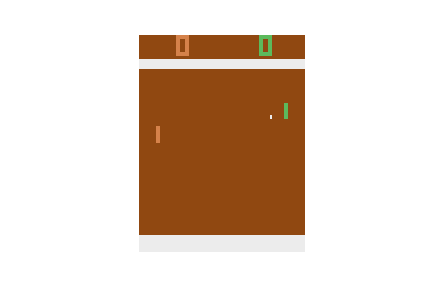
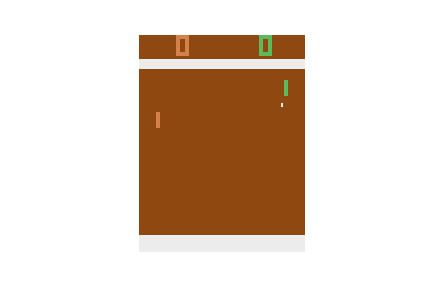
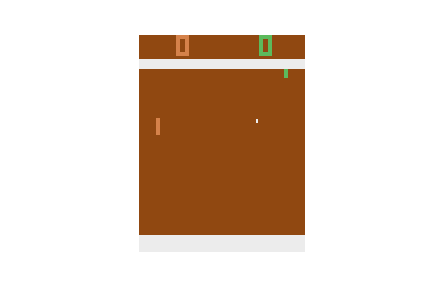
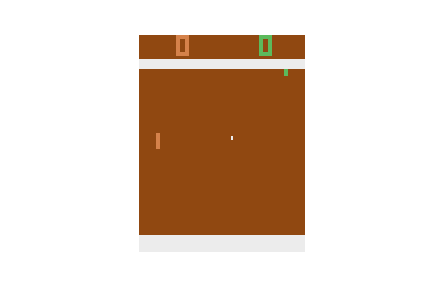
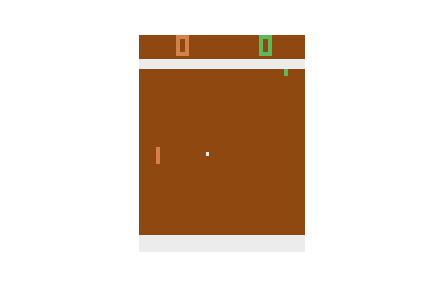
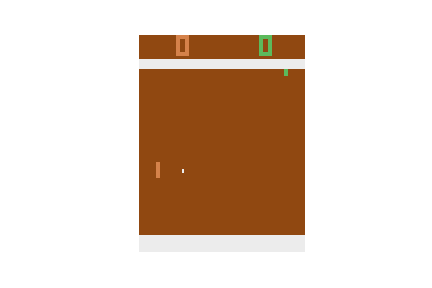
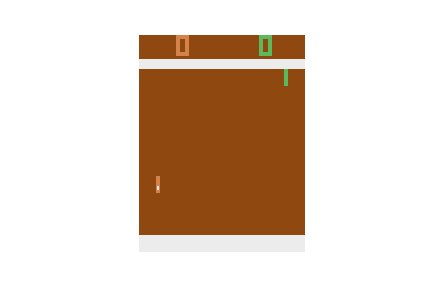
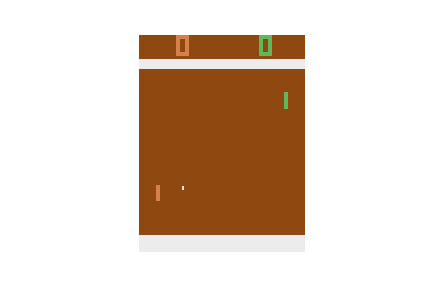
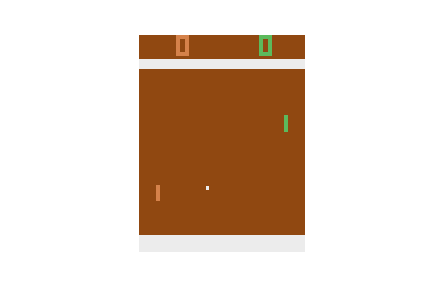
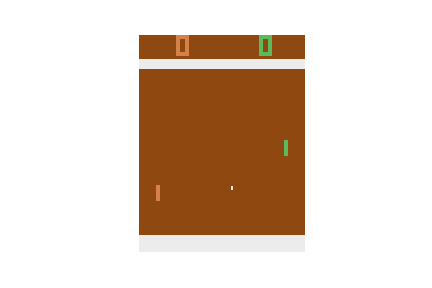
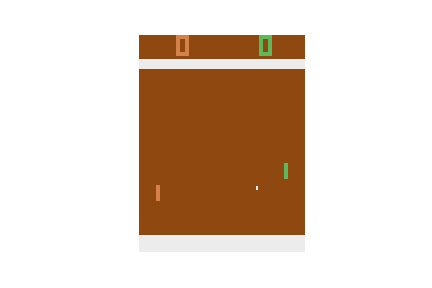
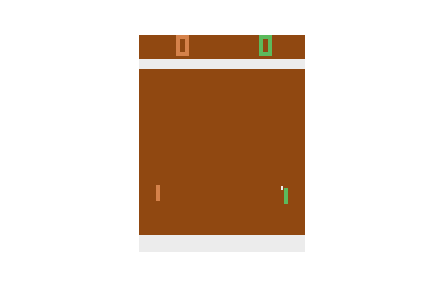
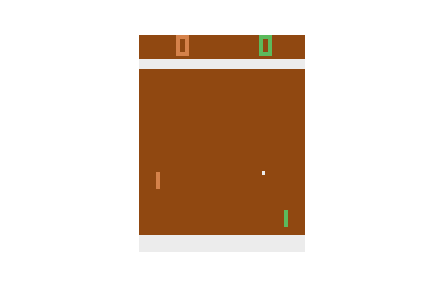
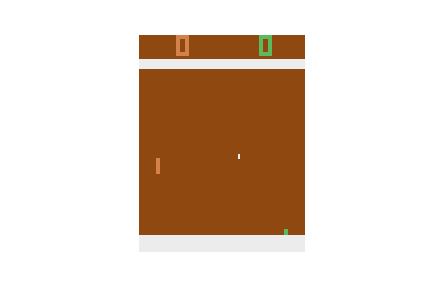
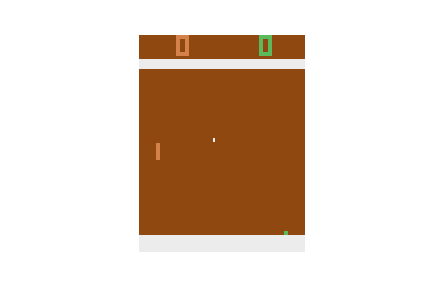
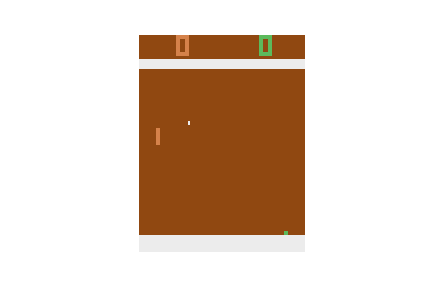
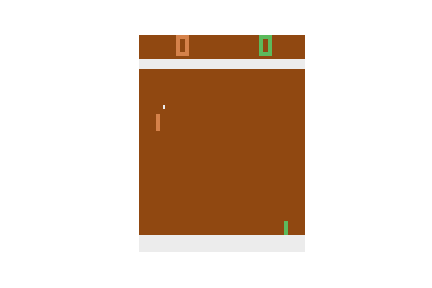
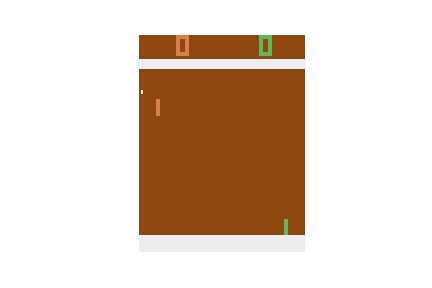
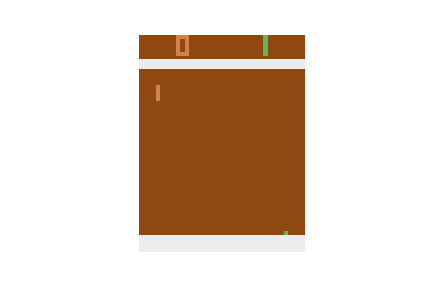
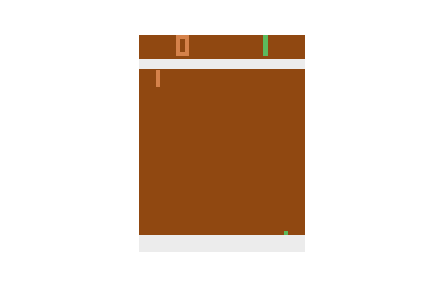
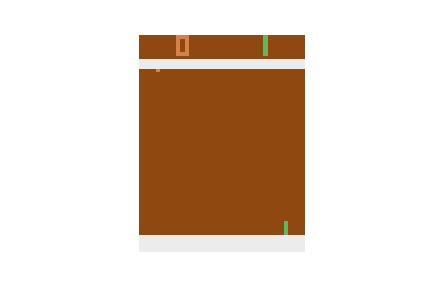
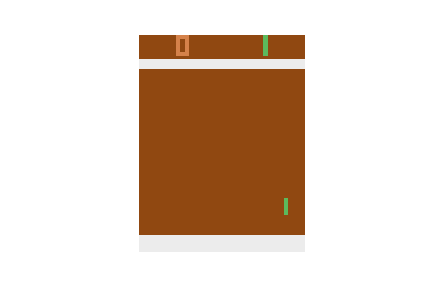
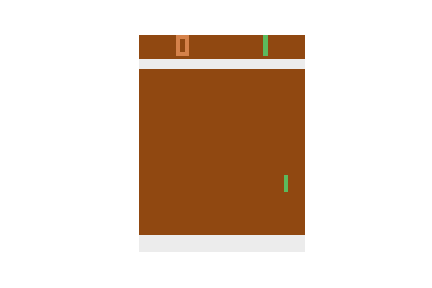
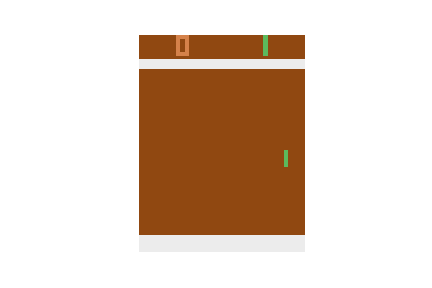
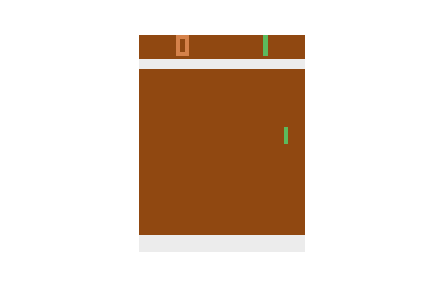
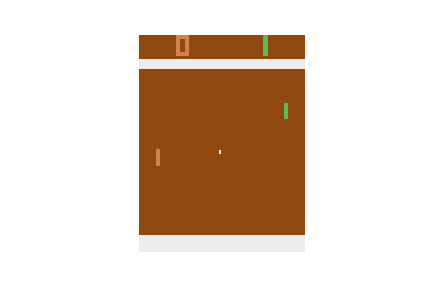
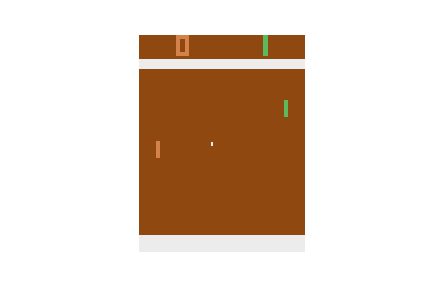
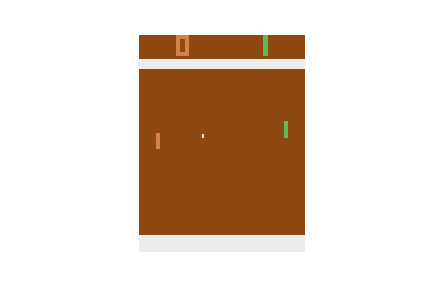
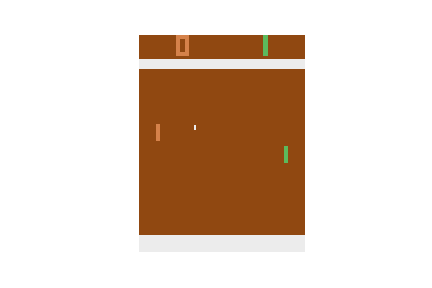
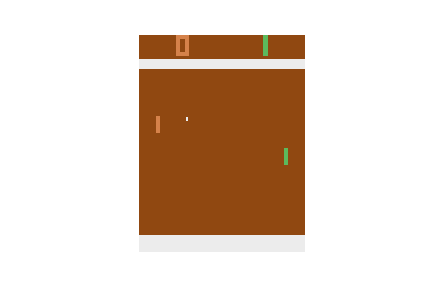
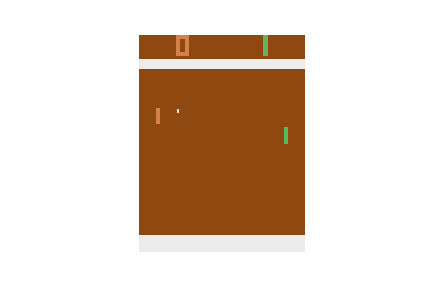
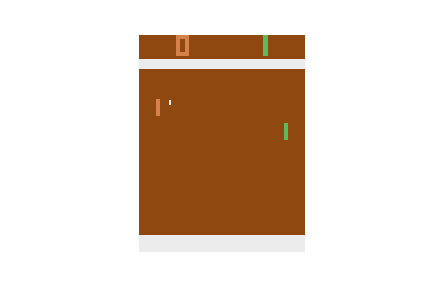
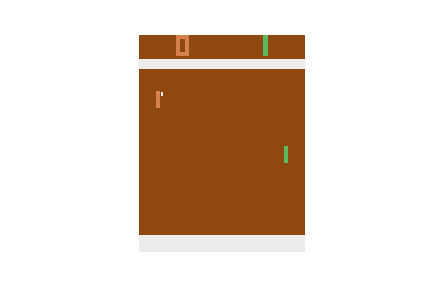
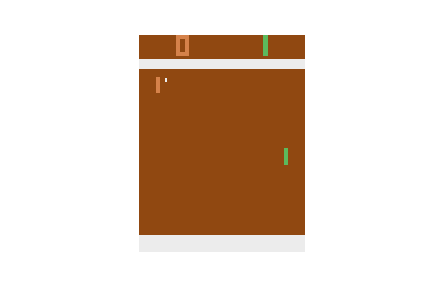
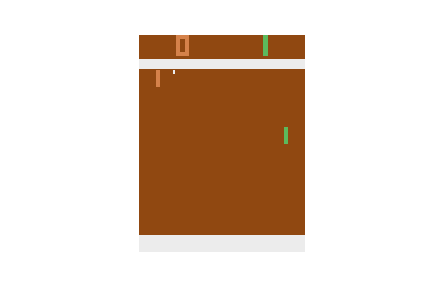
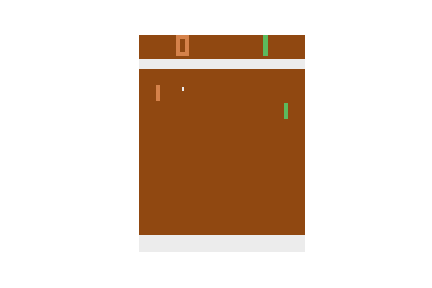
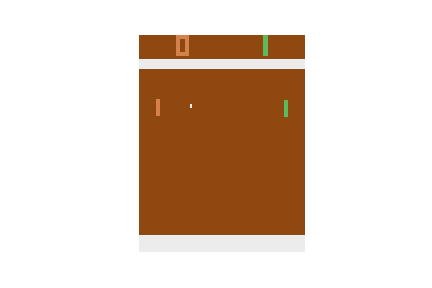
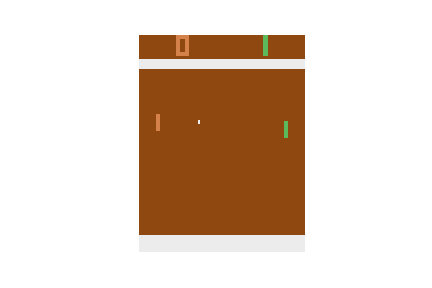
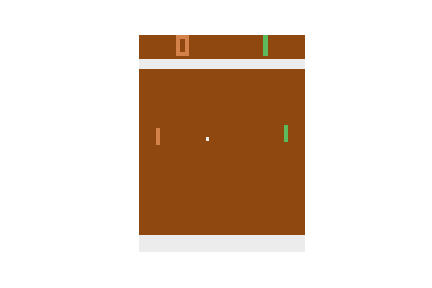
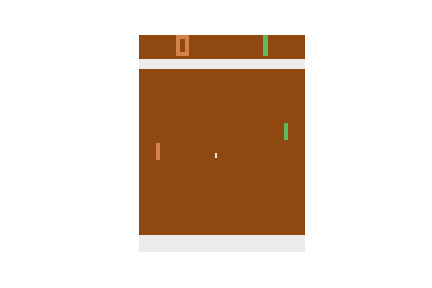
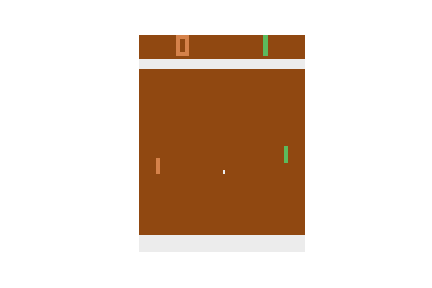
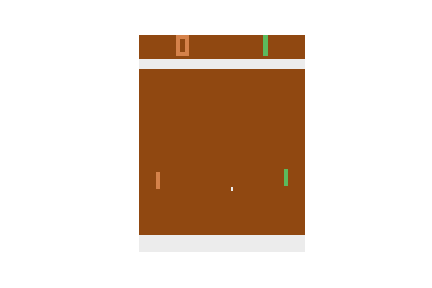
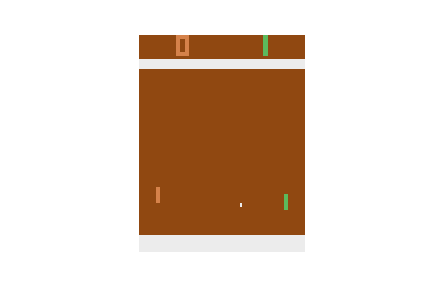
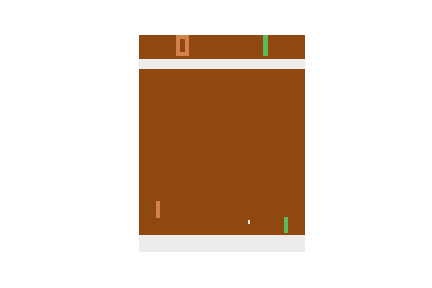
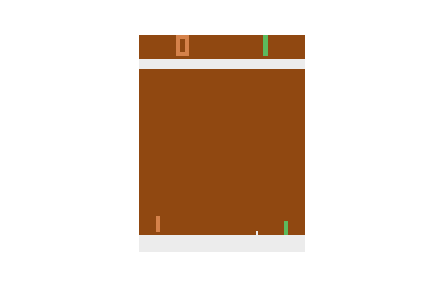
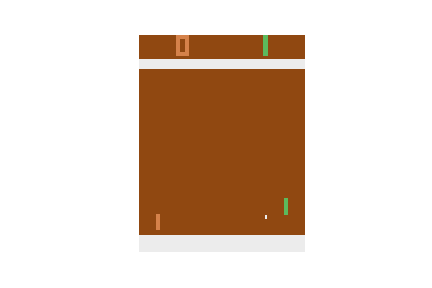
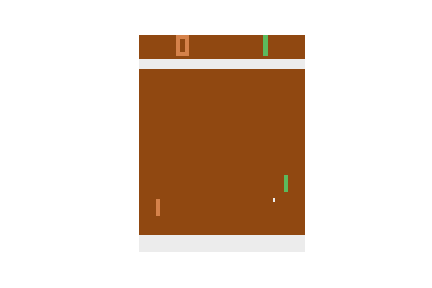
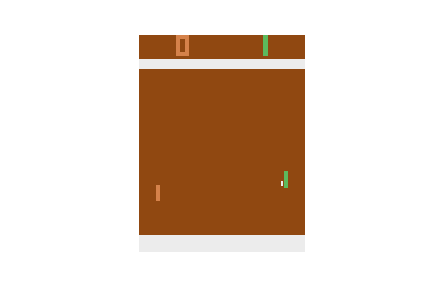
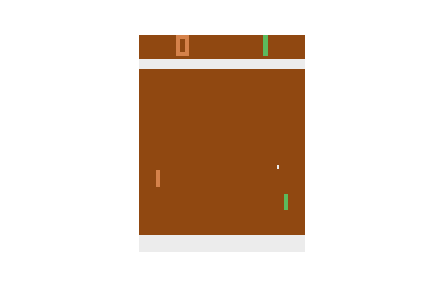
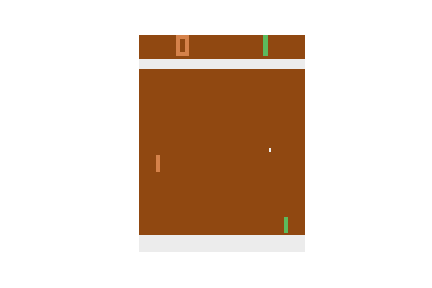
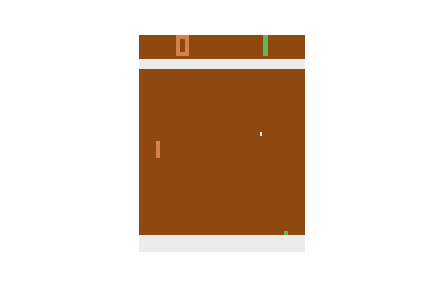
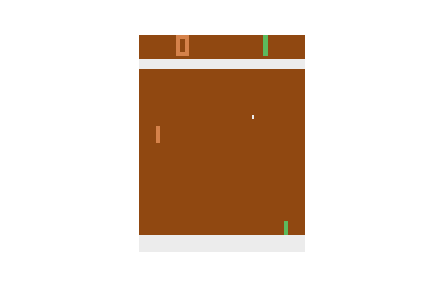
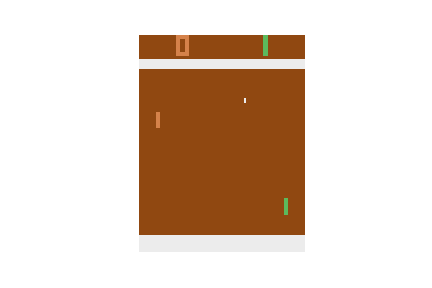
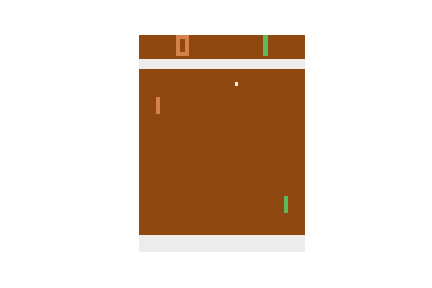
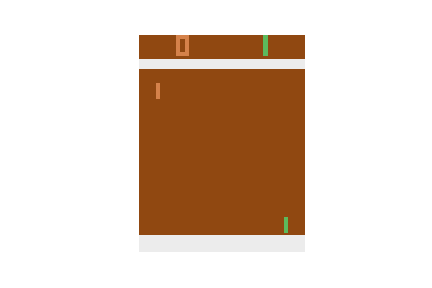
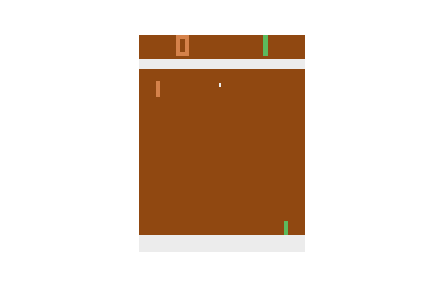
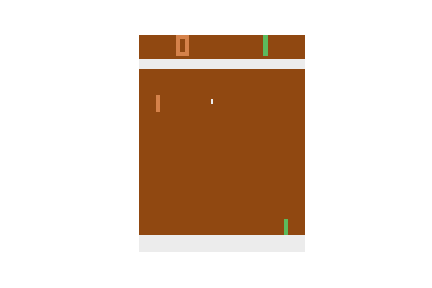
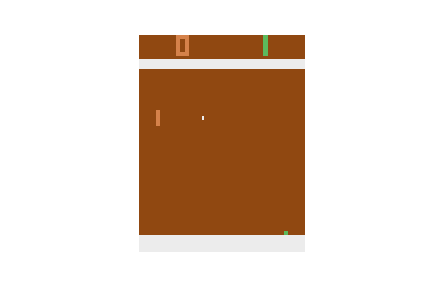
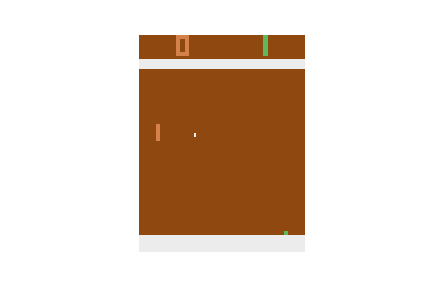
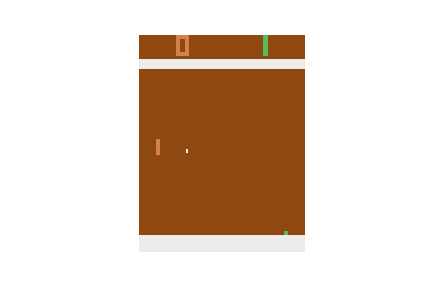
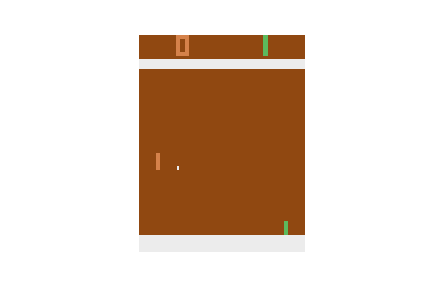
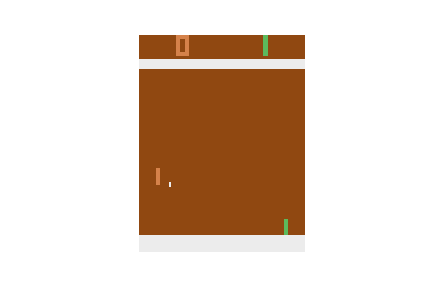
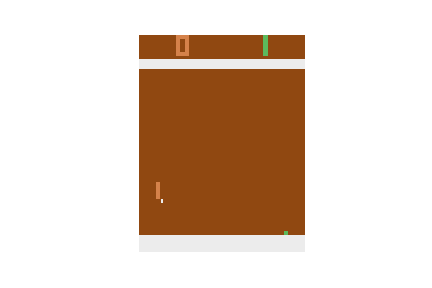
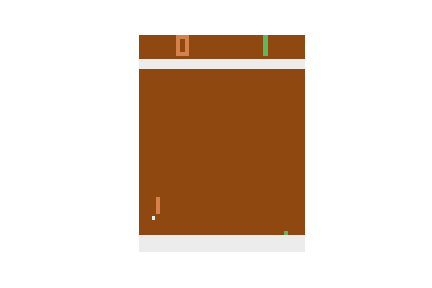
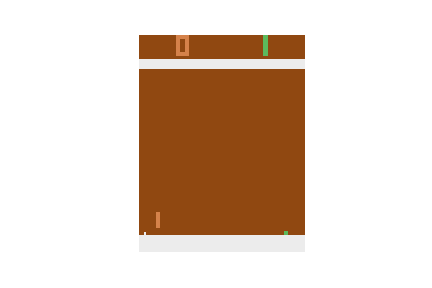
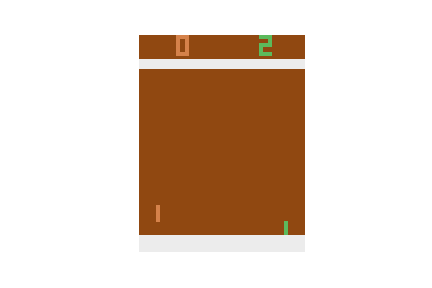
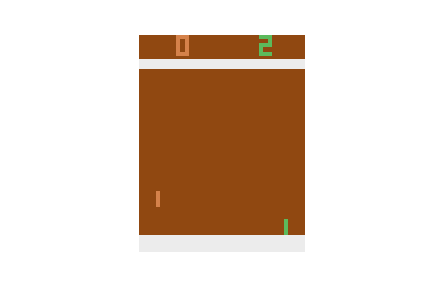
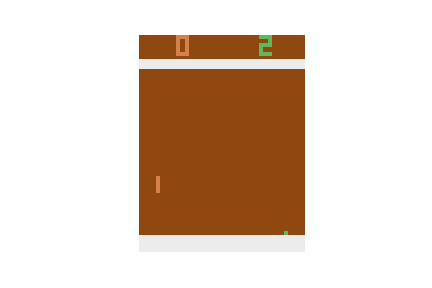
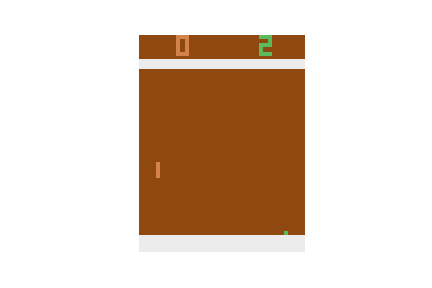
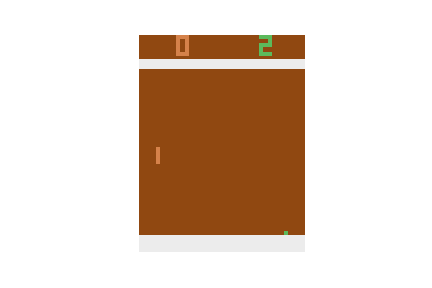
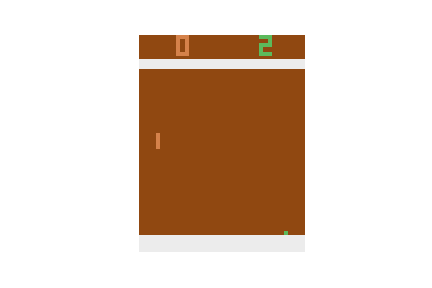
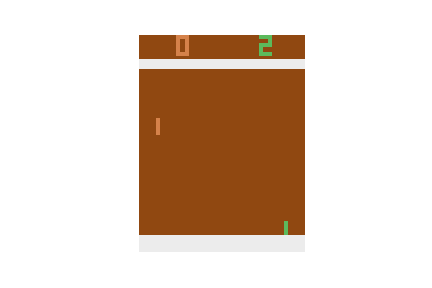
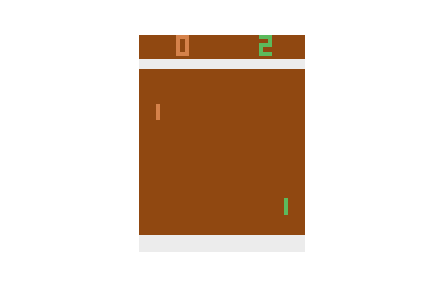
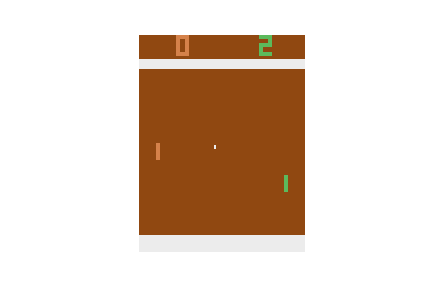
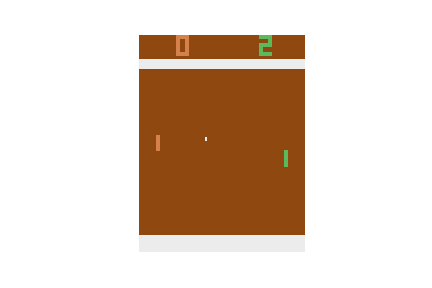
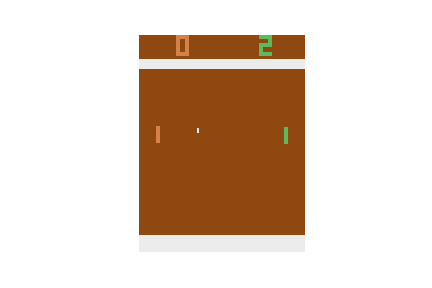
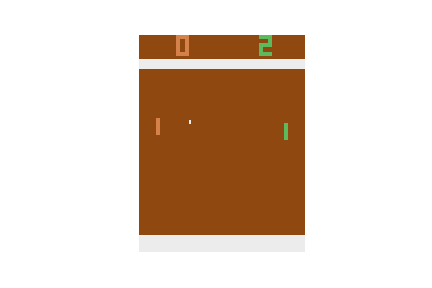
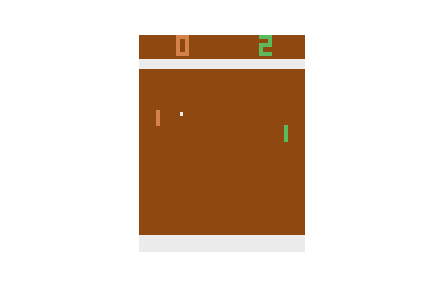
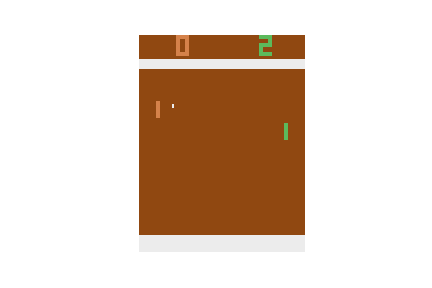
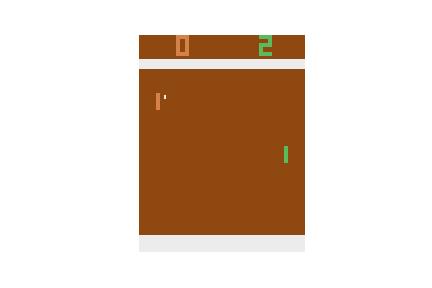
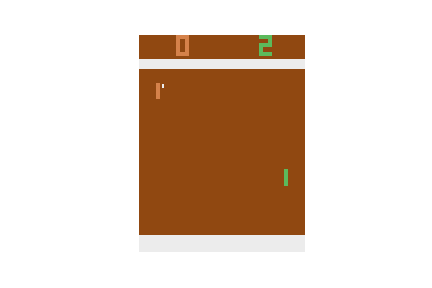
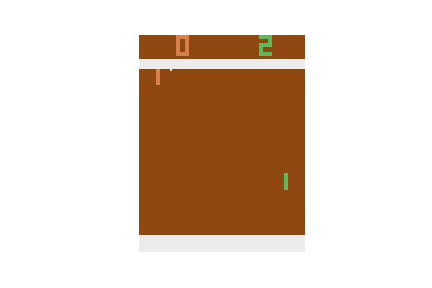
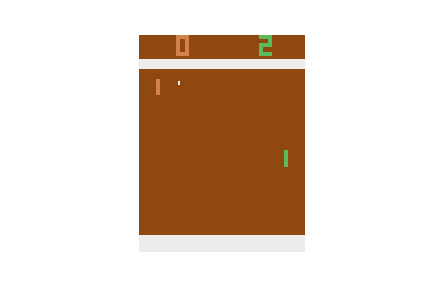
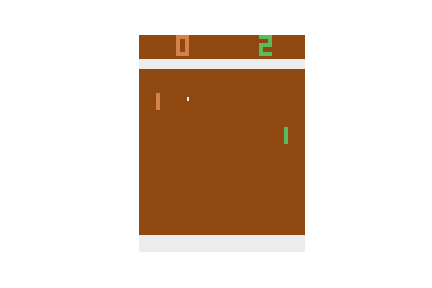
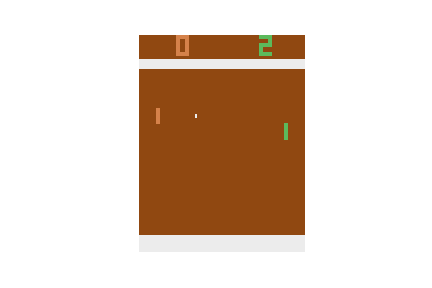
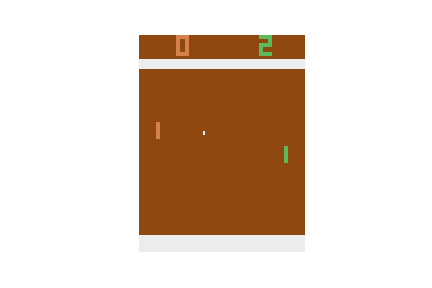
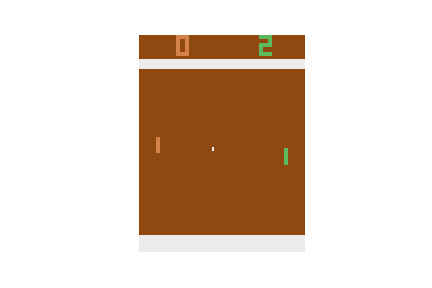
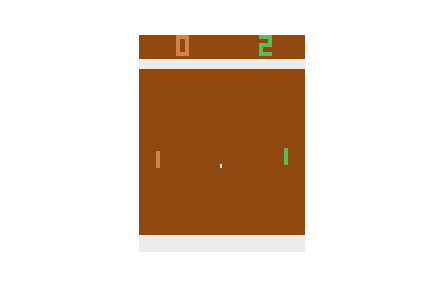
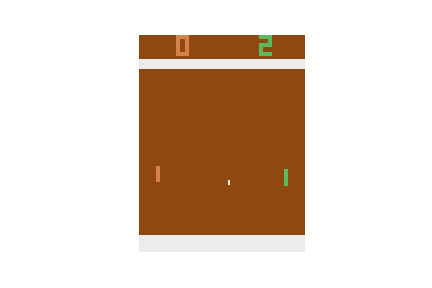
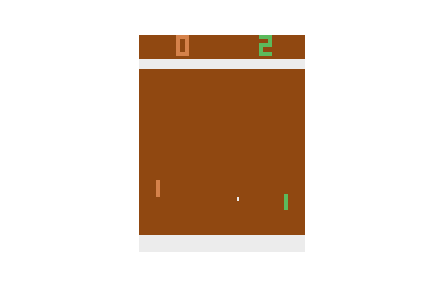
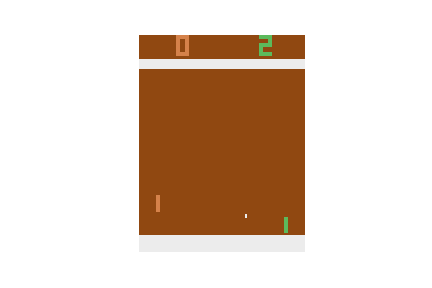
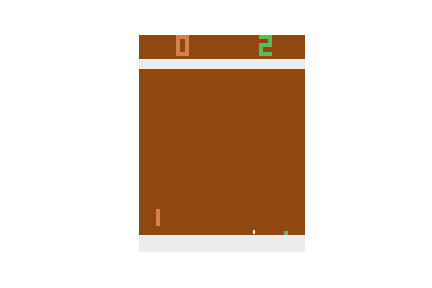
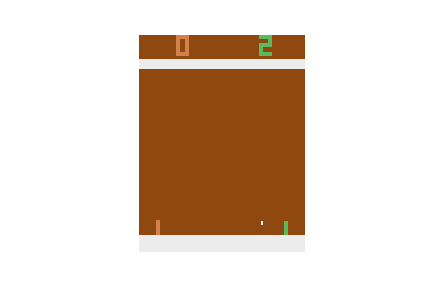
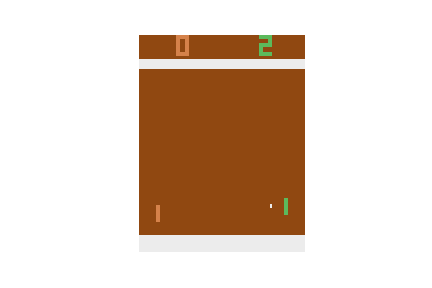
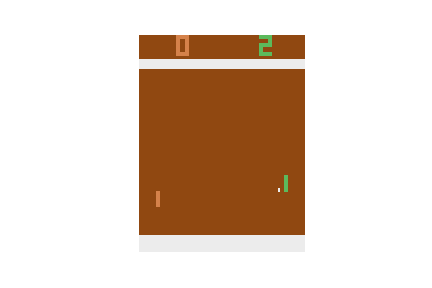
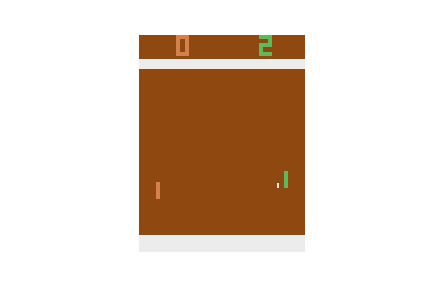
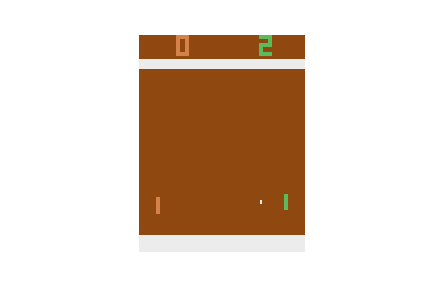
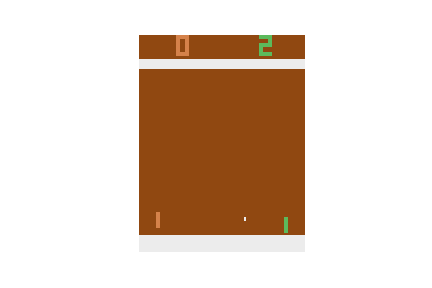
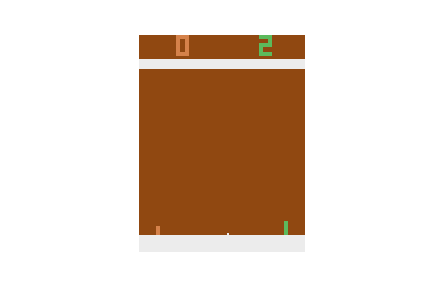
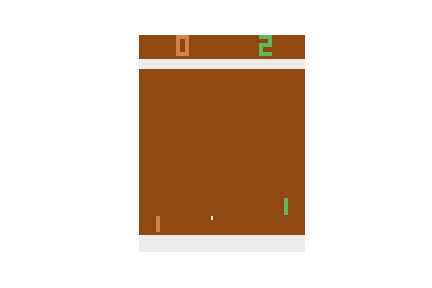
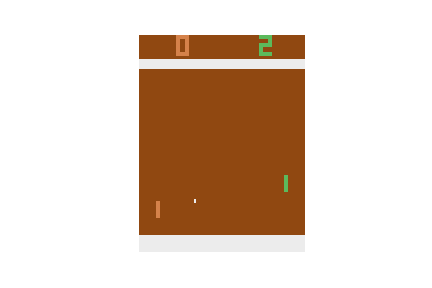
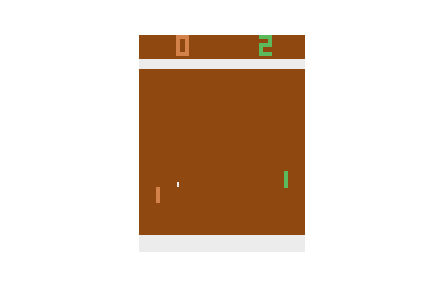
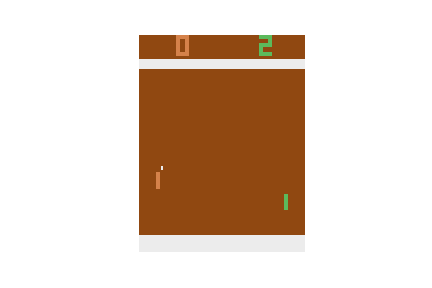
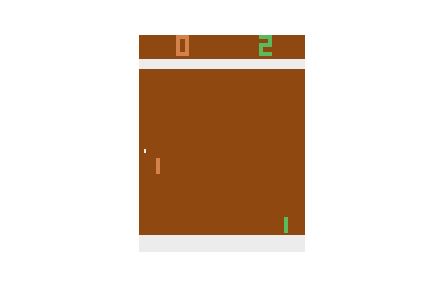
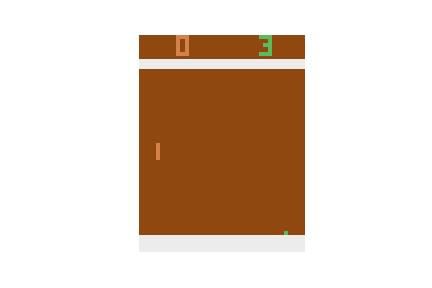
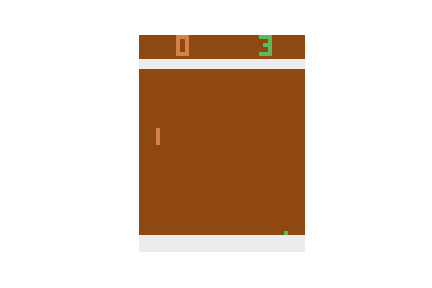
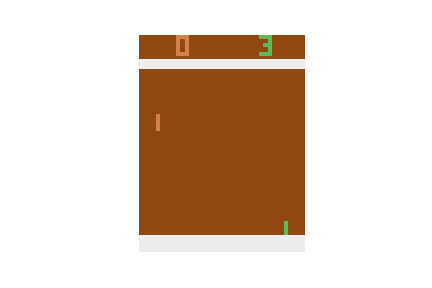
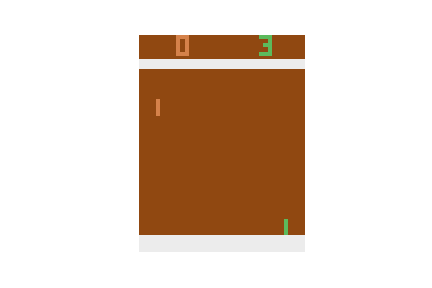
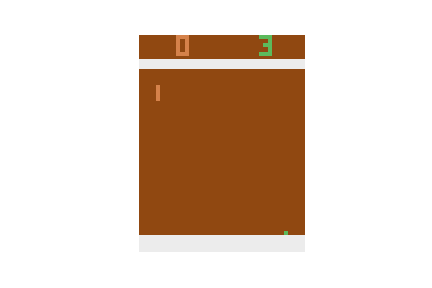
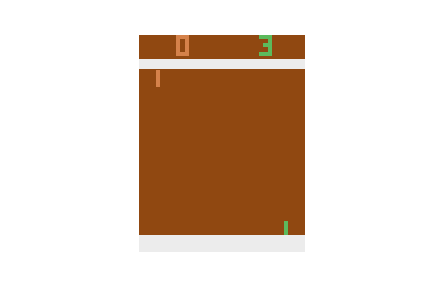
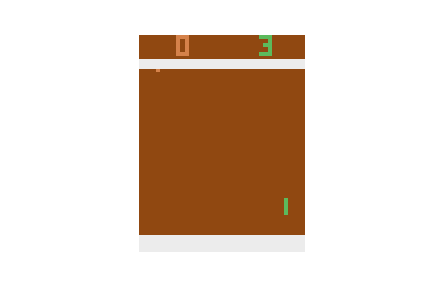
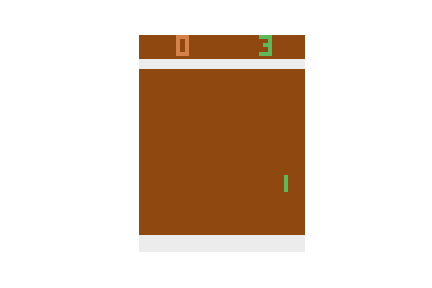
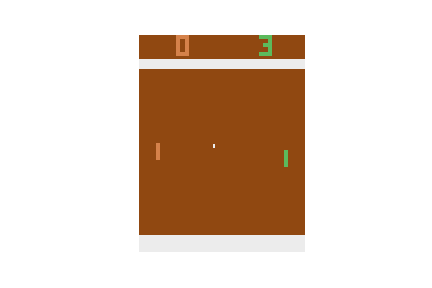
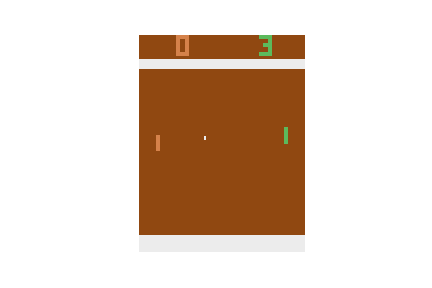
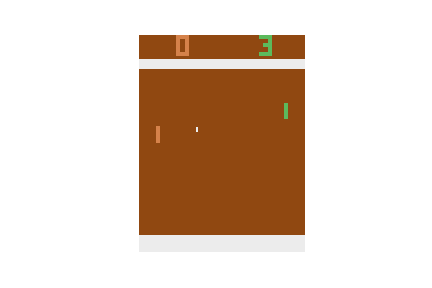
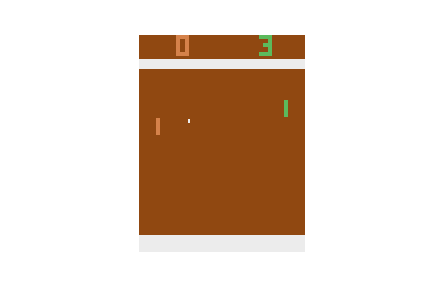
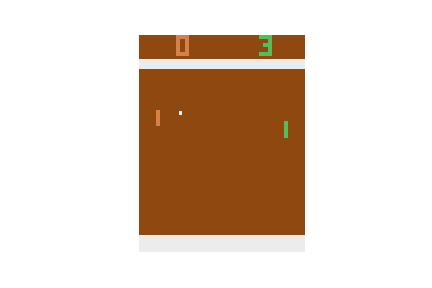
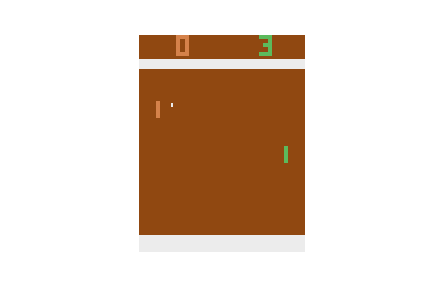
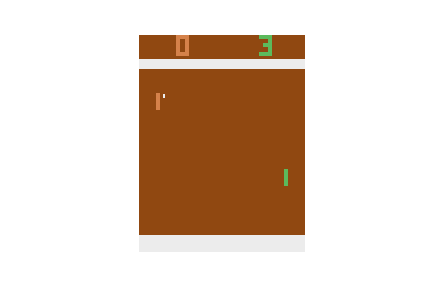
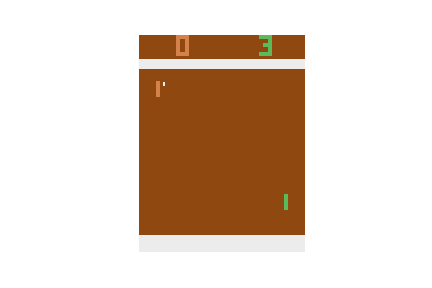
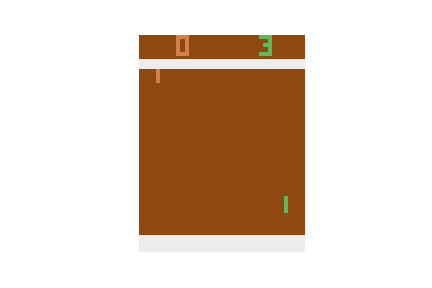
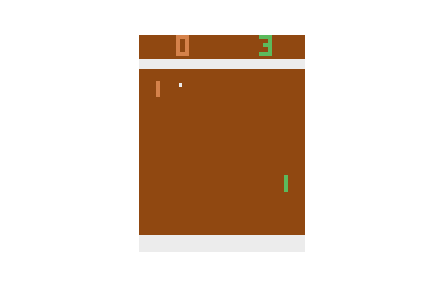
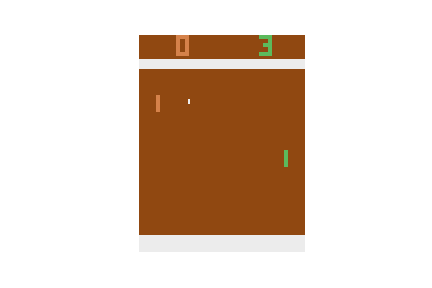
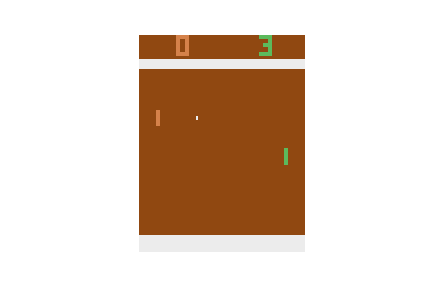
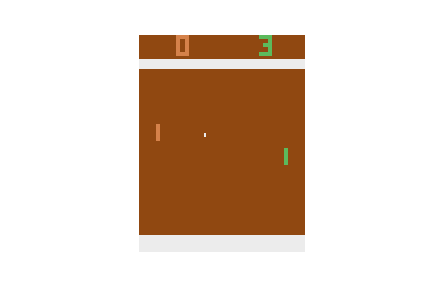
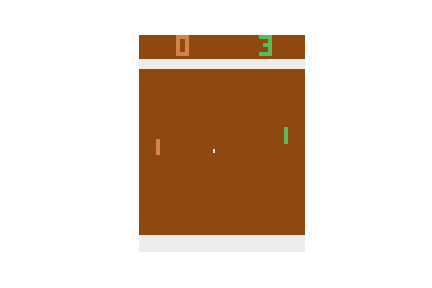
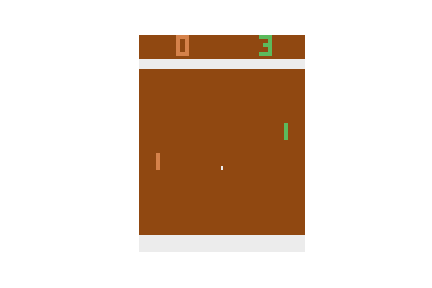
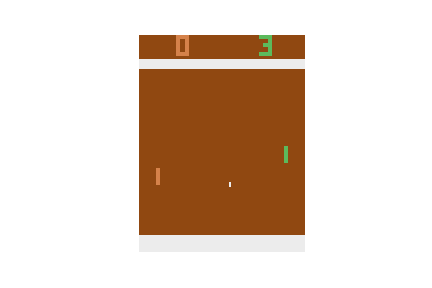
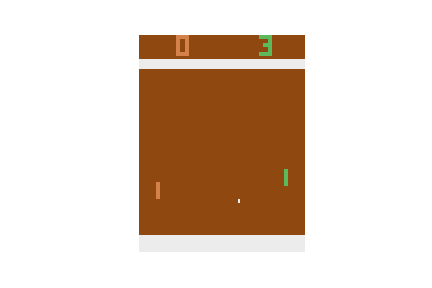
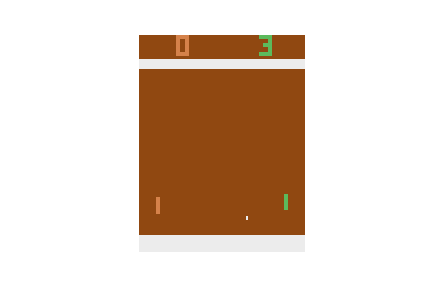
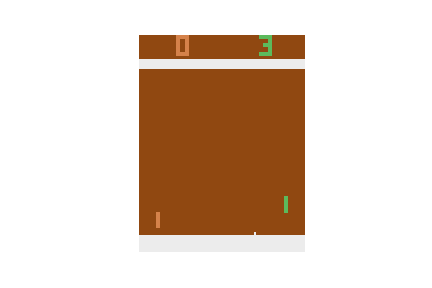
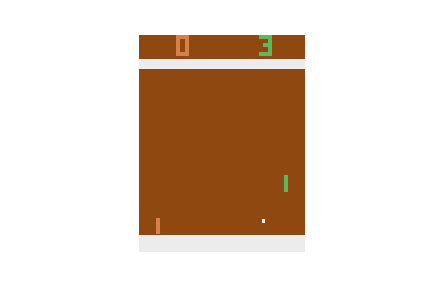
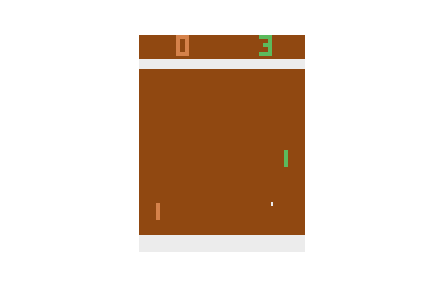
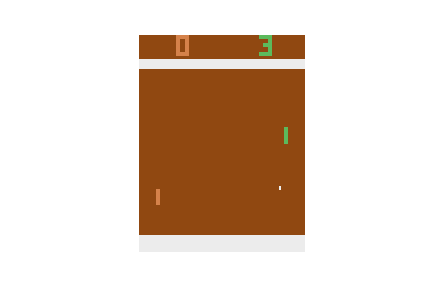
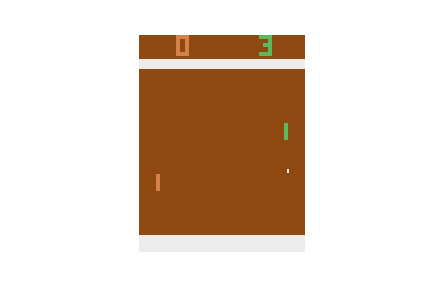
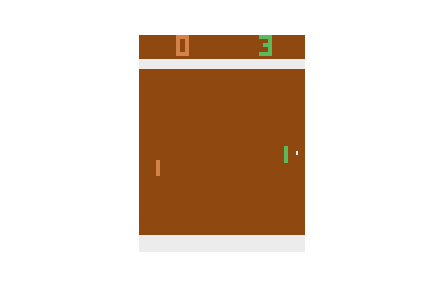
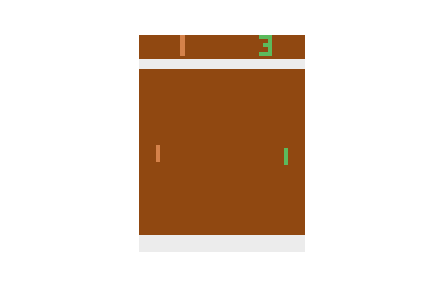
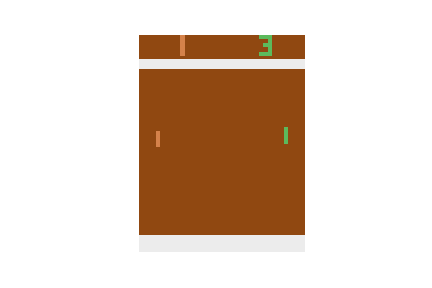
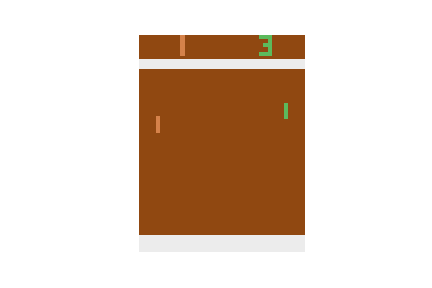
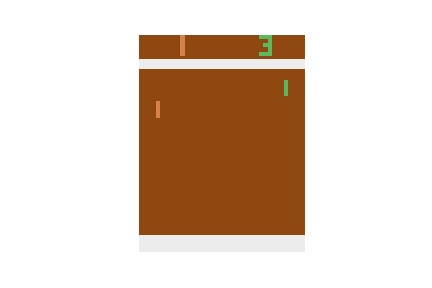
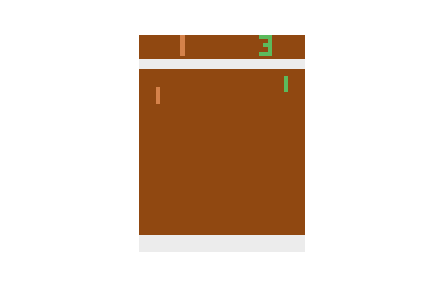
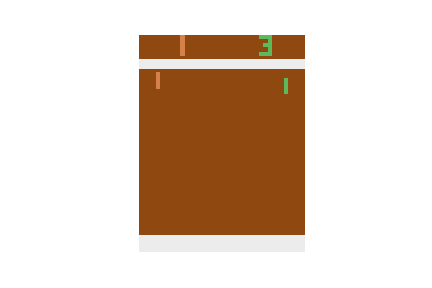
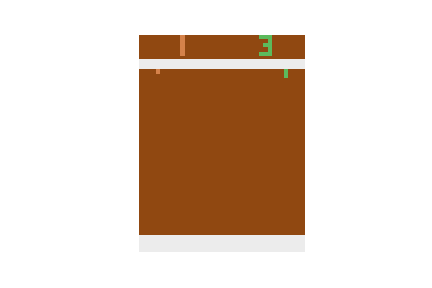
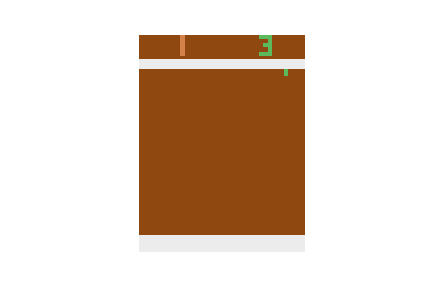
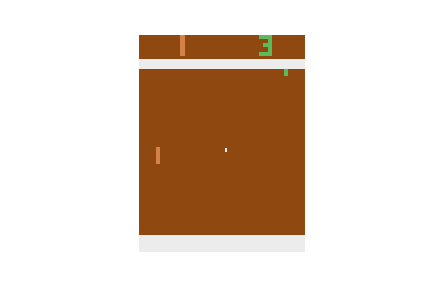
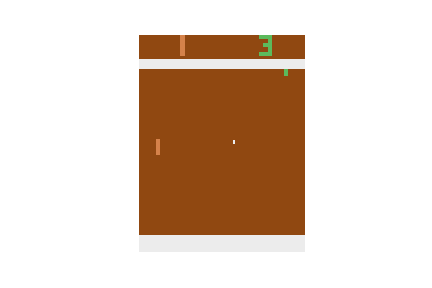
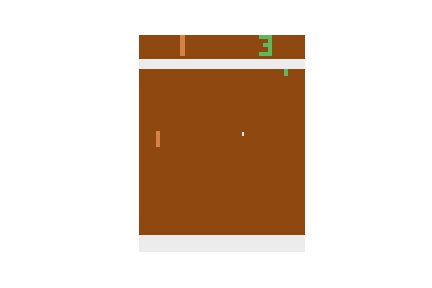
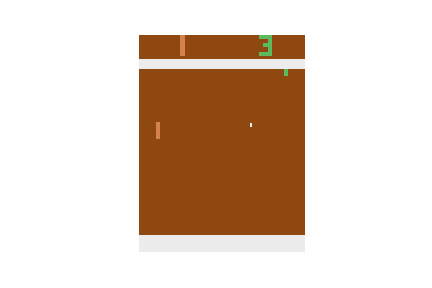
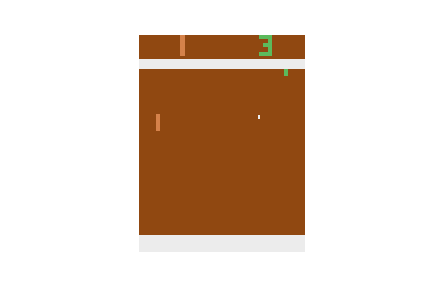
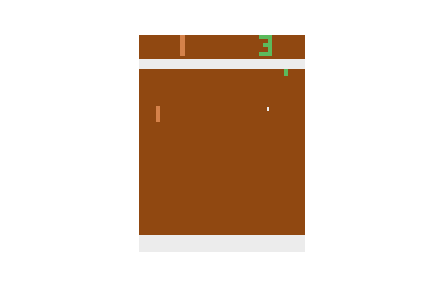
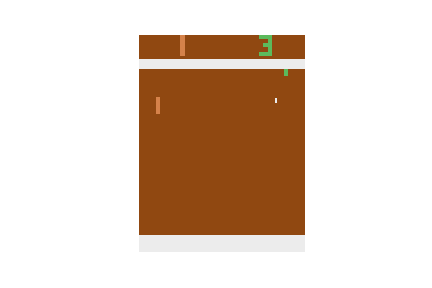
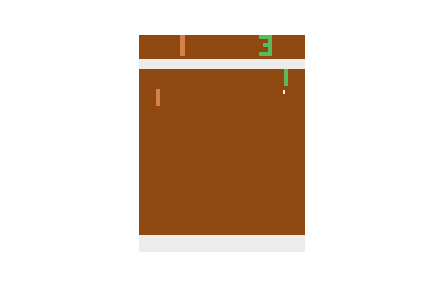
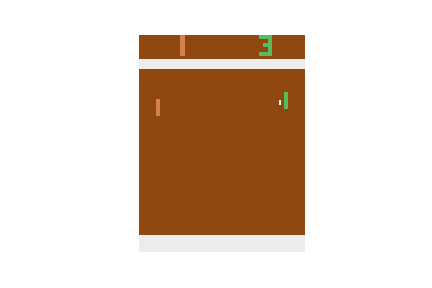
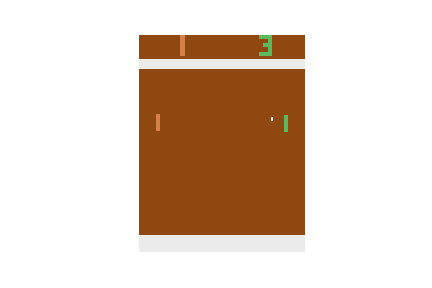
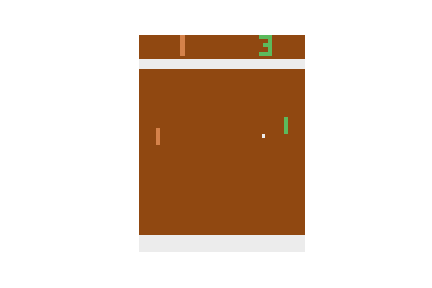
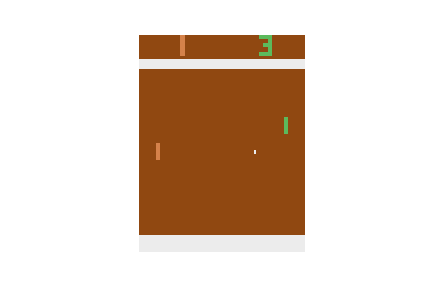
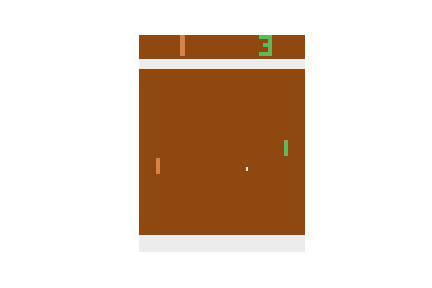
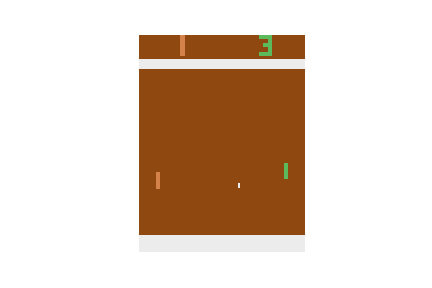
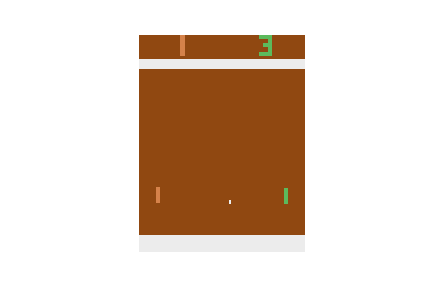
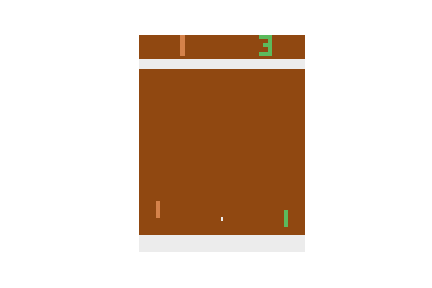
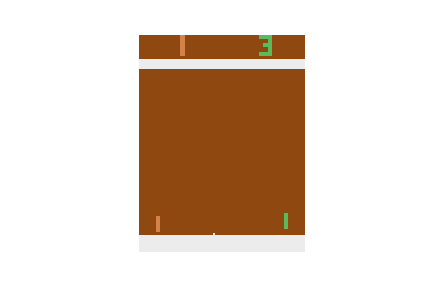

In [6]:
pong_utils.play(env, policy, time=200) 

In [7]:
# save your policy!
torch.save(policy, 'PPO.pth')